In [3]:
import os
import win32com.client as com

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
from collections import namedtuple, deque

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore")

### Activate Vissim 

In [4]:
cdict = {'red': ((0.0, 1.0, 1.0),
                 (0.125, 1.0, 1.0),
                 (0.25, 1.0, 1.0),
                 (0.5625, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.5625, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),
         'blue': ((0.0, 0.0, 0.0),
                  (0.5, 0.0, 0.0),
                  (1.0, 0.0, 0.0))}
my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)

In [391]:
# dispatch Vissim 10.0
Vissim = com.gencache.EnsureDispatch("Vissim.Vissim-64.10")

# vissim network file location
network = os.path.join(os.getcwd(), 'simulation','VSL_simulation.inpx')
layout = os.path.join(os.getcwd(), 'simulation','VSL_simulation.layx')

# Load network and layout
flag_read_additionally = True
Vissim.LoadNet(network, flag_read_additionally)
Vissim.LoadLayout(layout)
Vissim.SaveNetAs(network)

### real world environment setup

In [7]:
# Add desired 15-mins time interval
# TimeIntervalSet = 1   # 1 = VehicleInput
# for i in range(len(p1)-1):
#     Vissim.Net.TimeIntervalSets.ItemByKey(TimeIntervalSet).TimeInts.AddTimeInterval(0) # unsigned int Key

In [8]:
def dynamic_vol(sensor, df_path='./data/raw.csv'):
    df_input = pd.read_csv(df_path,delimiter=',')
    raw_vol = df_input[(df_input.Sensor == sensor)]
    raw_vol['time'] = raw_vol.hh * 60 + raw_vol.mm
    raw_vol = raw_vol[(raw_vol.time > 895)&(raw_vol.time < 1110)]
    raw_vol['Time'] = raw_vol.time//15
    raw_input = raw_vol.groupby(['Sensor','Time'])['hourly_v','Speed','Count'].mean().reset_index()
    raw_input.Time = raw_input.Time * 15
    return raw_input

In [9]:
# Enter Ramp Volume
p1 = dynamic_vol('EB to 86th STREET-EB')
p4 = dynamic_vol('I-35/80 EB @ Iowa 28')
portion = p4.hourly_v.sum()/p1.hourly_v.sum() - 1.0
# R1 = list(round(0.2*1*(p4.hourly_v - p1.hourly_v)))
# R2 = list(round(0.3*1*(p4.hourly_v - p1.hourly_v)))
# R3 = list(round(0.5*1*(p4.hourly_v - p1.hourly_v)))
R1 = list(round(p1.hourly_v * portion * 0.05))
R2 = list(round(p1.hourly_v * portion * 0.2))
R3 = list(round(p1.hourly_v * portion * 0.75))

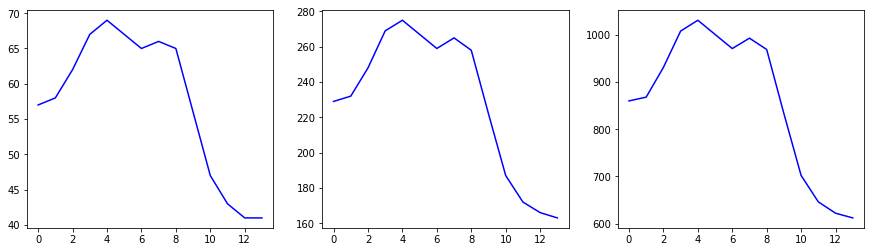

In [14]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.plot(R1, c='blue')
plt.subplot(132)
plt.plot(R2, c='blue')
plt.subplot(133)
plt.plot(R3, c='blue')
plt.show()

In [15]:
## Assign Volume
# for p,v,r1,r2,r3 in zip(range(1, len(p1)+1), list(p1.hourly_v),R1,R2,R3):
#     Vissim.Net.VehicleInputs.ItemByKey(1).SetAttValue('Volume({})'.format(p),v)
#     Vissim.Net.VehicleInputs.ItemByKey(2).SetAttValue('Volume({})'.format(p),r1)
#     Vissim.Net.VehicleInputs.ItemByKey(3).SetAttValue('Volume({})'.format(p),r2)
#     Vissim.Net.VehicleInputs.ItemByKey(4).SetAttValue('Volume({})'.format(p),r3)
# Vissim.SaveNetAs(network)

In [24]:
# test run
Vissim.Simulation.Stop()
Vissim.Graphics.CurrentNetworkWindow.SetAttValue("QuickMode",1) # activate quickmode
Vissim.Simulation.RunContinuous()
Vissim.Simulation.Stop()

In [81]:
def get_speed(id_time):
    res = np.zeros((8*40,4),dtype='object')
    for i in range(1,9):
        DC_measurement = Vissim.Net.DataCollectionMeasurements.ItemByKey(i)
        res[i-1,0] = DC_measurement.AttValue('Name')
        res[i-1,1] = DC_measurement.AttValue('Vehs    (Current,{},All)'.format(id_time))
        res[i-1,2] = DC_measurement.AttValue('Speed       (Current,{},All)'.format(id_time)) # Speed of vehicles
        res[i-1,3] = DC_measurement.AttValue('OccupRate       (Current,{},All)'.format(id_time))
    res = pd.DataFrame(res,columns=['Name','vehs','speed','occ'])
    res = res.iloc[0:8]
    return res

In [82]:
def speed_dist():
    all_res = []
    for i in range (1,41):
        block = get_speed(i)
        block['time_interval'] = i
        all_res.append(block)
    all_res = pd.concat(all_res)
    all_res['vehs'] = all_res['vehs'].astype('float')
    all_res['speed'] = all_res['speed'].astype('float')
    all_res['time_interval'] = all_res['time_interval'].astype('float')
    return all_res

In [83]:
def povit_shape(res_):
    res = pd.pivot_table(res_, index=['Name'], columns=['time_interval'], values=['speed'])
    res.columns = [i+str(int(j)) for i,j in res.columns]
    #res = np.array(res.reset_index())
    return res

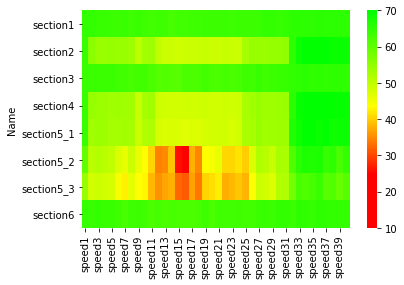

In [90]:
speed_heat = povit_shape(speed_dist())
plt.figure(figsize=(6, 4))
sns.heatmap(speed_heat, cmap=my_cmap,cbar=True, vmin=10, vmax=70)
plt.show()

In [28]:
# all_res = all_res.groupby('time_interval').agg({'vehs':'sum', 'speed':'mean'}).reset_index()
# # agg_res = all_res.copy()
# all_res['time_interval'] = 600 + (all_res['time_interval']-1) * 300

In [29]:
# # Simulation parameters setting
# Vissim.Simulation.Stop()
# End_of_simulation = 12600 # total running time
# Vissim.Simulation.SetAttValue('SimPeriod', End_of_simulation)
# Sim_break_at = 900 # break simulation every 5-mins
# Vissim.Simulation.SetAttValue('SimBreakAt', Sim_break_at)
# Vissim.Simulation.SetAttValue('UseMaxSimSpeed', True)
# Vissim.Simulation.SetAttValue('RandSeed', 42)

In [30]:
# # simulation run
# Vissim.Simulation.Stop()
# for simRun in Vissim.Net.SimulationRuns:
#     Vissim.Net.SimulationRuns.RemoveSimulationRun(simRun) # clean previous simulation run

# Vissim.Graphics.CurrentNetworkWindow.SetAttValue("QuickMode",1) # activate quickmode
# Vissim.Simulation.RunContinuous()
# Vissim.Graphics.CurrentNetworkWindow.SetAttValue("QuickMode",0) # deactivate quickmode
# Vissim.SuspendUpdateGUI()
# Vissim.ResumeUpdateGUI(True)
# Vissim.Simulation.RunSingleStep()
# Vissim.Simulation.Stop()

### Vissim simulator environment

In [361]:
def get_link():
    link_info = np.array((Vissim.Net.Links.GetMultipleAttributes(['Name','Numlanes','Length2D','LinkEvalAct'])),dtype='object')
    link_info = link_info[link_info[:,-1]==1][:,:-1]
    link_info = pd.DataFrame(link_info,columns=['Name','Numlanes','length'])
    return link_info

In [17]:
def get_collection(links):
    res = np.zeros((len(links),4),dtype='object')
    for i in range(1,len(links)+1):
        DC_measurement = Vissim.Net.DataCollectionMeasurements.ItemByKey(i)
        res[i-1,0] = DC_measurement.AttValue('Name')
        res[i-1,1] = DC_measurement.AttValue('Vehs    (Current,last,All)')
        res[i-1,2] = DC_measurement.AttValue('Speed       (Current,last,All)') # Speed of vehicles
        res[i-1,3] = DC_measurement.AttValue('OccupRate       (Current,last,All)')
    res = pd.DataFrame(res,columns=['Name','vehs','speed','occ'])
    return res

In [18]:
def los_partition(k_i):
    bins=[0,11,18,26,35,45,100] # LOS criterias
    parts = len(bins)-1
    seqs=np.zeros((len(k_i)),dtype=np.int)
    for k in range(0, parts):
        seqs[np.logical_and(k_i>=bins[k],k_i<=bins[k+1])]=k+1
    return seqs

In [19]:
def get_state():
    # get link info
    link_info = get_link()
    # get data collection info
    res = get_collection(link_info)
    # append lanes numbers
    out = pd.merge(link_info,res,left_on='Name',right_on='Name')
    out['k_lane'] = out.vehs*12/out.speed/out.Numlanes
    # out['Name'] = out.Name.str[0:8]
    # out[['length','vehs','speed','occ','k_lane']] = out[['length','vehs','speed','occ','k_lane']].astype(np.float)
    #out = out.groupby('Name')['vehs','speed','occ','k_lane'].mean().reset_index()
    out['LOS'] = los_partition(out.k_lane)
    out['avg_tt'] = 3600*(out.length/5280)/out.speed
    return out

In [166]:
def get_delay_stop():
    avg_delay = Vissim.Net.VehicleNetworkPerformanceMeasurement.AttValue('DelayAvg (Current,last,All)')
    avg_stop = Vissim.Net.VehicleNetworkPerformanceMeasurement.AttValue('STOPSAVG (Current,last,All)')
    active_vehicle = Vissim.Net.VehicleNetworkPerformanceMeasurement.AttValue('VEHACT (Current,last,All)')
    arrived_vehicle = Vissim.Net.VehicleNetworkPerformanceMeasurement.AttValue('VEHARR (Current,last,All)')
    res = pd.DataFrame({'avg_delay':[avg_delay],'avg_stop':[avg_stop],
                        'active_vehicle':[active_vehicle], 'arrived_vehicle':[arrived_vehicle]})
    return res

In [23]:
def get_travltime(links):
    res = np.zeros((len(links),3),dtype='object')
    for i in range(1,len(links)+1):
        TT_measurement =Vissim.Net.VehicleTravelTimeMeasurements.ItemByKey(i)
        res[i-1,0] = TT_measurement.AttValue('Name')
        res[i-1,1] = TT_measurement.AttValue('TravTm (Current,last,All)')
        res[i-1,2] = TT_measurement.AttValue('DISTTRAV (Current,last,All)')
    res = pd.DataFrame(res,columns=['Name','traveltime','dist'])
    return res

In [238]:
def get_res():
    # Getting state 
    df_state = get_state()
    state_vec = np.array((df_state.LOS),dtype='int')
    # Getting action 
    action_vec = np.array([10050,10055,10060,10065,10070, 10075,10080,10085])
    # Getting reward 
    df_delay = get_delay_stop()
    evaluate_df = np.array(df_delay).squeeze()
    rewards = np.array((df_delay.avg_delay+ df_delay.avg_stop) * (-1)) # 
    # df_rewards = get_travltime(state_vec)
    # rewards_vec = np.array(df_rewards.traveltime,dtype='float').sum() * (-1)
    tt = np.array(df_state.avg_tt,dtype='float')
    evaluate_df = np.append(evaluate_df, tt.sum())
    return state_vec, action_vec, rewards, evaluate_df

In [239]:
# dynamic speed changes
def assign_VSL(speed_limit):
    for i in range(1, len(Vissim.Net.DesSpeedDecisions.GetAll())+1):
        if Vissim.Net.DesSpeedDecisions.ItemByKey(i).AttValue('Name') == 'S1_65MPH':
            # Car speed distribution
            Vissim.Net.DesSpeedDecisions.ItemByKey(i).SetAttValue('DesSpeedDistr(10)',speed_limit)
            # HGV speed distribution
            Vissim.Net.DesSpeedDecisions.ItemByKey(i).SetAttValue('DesSpeedDistr(20)',speed_limit)
        else:
            pass
    #return print('VSL Changed.')

In [240]:
S, A, R, evaluate_df = get_res()

In [241]:
S, A, R

(array([2, 2, 2, 2, 2, 2, 3, 2]),
 array([10050, 10055, 10060, 10065, 10070, 10075, 10080, 10085]),
 array([-2.95264257]))

In [242]:
evaluate_df

array([173.        , 289.        ,   2.95264257,   0.        ,
       233.87791427])

In [362]:
class vissim_environment():
    
    def __init__(self,
                 Initial_sim_break = 900, # 1st env state
                 End_of_simulation = 12600, 
                 action_space = np.array([10050,10055,10060,10065,10070,10075,10080,10085])):

        self.action_space = action_space
        self.End_of_simulation = End_of_simulation
        self.Initial_sim_break = Initial_sim_break
        #print('Environment Created.')
    
    def reset(self, initial_speed, vissim_seed = np.random.randint(1, 10**5)):
        # reset the simulation with random seed and get the first stage as initial state input.
        Vissim.Simulation.Stop()
        # assign initial speed limit
        assign_VSL(10000+initial_speed)
        speed_dis_check = Vissim.Net.DesSpeedDecisions.ItemByKey(1).AttValue('DesSpeedDistr(10)')
        #print(speed_dis_check)
                 
        for simRun in Vissim.Net.SimulationRuns:
            Vissim.Net.SimulationRuns.RemoveSimulationRun(simRun) # clean previous simulation run
        
        Vissim.Simulation.SetAttValue('RandSeed', vissim_seed)
        Vissim.Simulation.SetAttValue('UseMaxSimSpeed', True)
        Vissim.Simulation.SetAttValue('SimBreakAt', self.Initial_sim_break)
        Vissim.Simulation.SetAttValue('SimPeriod', self.End_of_simulation)
        Vissim.Graphics.CurrentNetworkWindow.SetAttValue("QuickMode",1) # activate quickmode
        Vissim.Simulation.RunContinuous()
        init_state, _, init_reward, evaluate_df = get_res()
        return init_state, init_reward ,evaluate_df
        
    def step(self, id_action, sim_break):
        # simulator run one step given action and next 5-mins data collection points 
        action = str(self.action_space[id_action])
        assign_VSL(action)
        speed_dis_check = Vissim.Net.DesSpeedDecisions.ItemByKey(1).AttValue('DesSpeedDistr(10)')
        #print('VSL: {}'.format(int(speed_dis_check)-10000))
        # break point
        Sim_break_at = sim_break
        Vissim.Simulation.SetAttValue('SimBreakAt', Sim_break_at)
        Vissim.Simulation.RunContinuous()
        
        reward = 0.0
        done = False
        if sim_break == self.End_of_simulation:
            done = True
        state, _, reward, evaluate_df = get_res()
        
        return state, reward, done, evaluate_df
    
    def stop(self):
        Vissim.Simulation.Stop()

### DQNet

In [363]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [364]:
class DQnet(nn.Module):
    def __init__(self, state_space, action_space, seed, fc12_nodes=16, fc23_nodes=16):
        super(DQnet, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_space, fc12_nodes, bias=True)
        self.fc2 = nn.Linear(fc12_nodes, fc23_nodes, bias=True)
        self.fc3 = nn.Linear(fc23_nodes, action_space, bias=True)
    # rewrite forward to generate result
    def forward(self, state):
        s = self.fc1(state)
        s = F.relu(s)
        s = self.fc2(s)
        s = F.relu(s)
        s = self.fc3(s)
        
        return s

### VSL Agent

In [366]:
memory_size = 10**5 # 5-mins step, (12600s - 900s)/300s + 1 = 40 steps for 1 simulation, expect run 200 simulation
batch_size = 8 # experience replay size

class replay_memory():
    
    def __init__(self, memory_size, batch_size, seed):
        
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
        self.memory = deque([],maxlen=memory_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        #print('Memory initialized.')
        
    def add(self, state, action, reward, next_state, done):
        exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(exp)
    
    def sample(self):
        experiences = random.sample(self.memory, self.batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self): # length hook
        return len(self.memory)

In [367]:
# Allocating tensor to CPU or GPU if availiable.
device = torch.device('cpu')
# parameters setting
LR = 5e-3        # learning rate 
Gamma = 0.95     # discount factor
alpha = 0.9999     # adaptive update the fixed target_net

# VSL Agent initialize
class VSL_Agent():
    
    def __init__(self, state_space, action_space, seed):
        
        self.state_space = state_space
        self.action_space = action_space
        # Build 2 network, eval net and target net, where eval_net update first
        self.Qnet_eval = DQnet(state_space, action_space, seed).to(device)
        self.Qnet_target = DQnet(state_space, action_space, seed).to(device)
        self.optimizer = optim.Adam(self.Qnet_eval.parameters(), lr=LR)
        # recall the experiences memory
        self.memory = replay_memory(memory_size,batch_size,seed)
        
        #print('Agent ready.')
        
    def act(self, state, eps):
        # Pick action under current state
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        # pick action by using the trained eval_net before parameters update
        self.Qnet_eval.eval() # fix dropout and BN values, evaluate/test mode, deactivate parameters updates
        with torch.no_grad(): # reduce the memory used, deactivate auto gradients requires_grad=False
            action_values = self.Qnet_eval(state) # new state vector pass to the layers and get values
        self.Qnet_eval.train() # activate train mode, allow parameters updates
        # print (action_values)
        # epsilon-greedy action selector
        if random.random() > eps:
            # select the speed limit with larger rewards
            action_values = action_values.cpu().data.numpy()
            return np.argmax(action_values)
        else:
            # random selection speed limit
            return random.choice(np.arange(self.action_space))

    def step(self, state, action, reward, next_state, done):
        # add new state to the memory
        self.memory.add(state, action, reward, next_state, done)
        if len(self.memory) >= batch_size:
            exp = self.memory.sample()
            self.learn(exp, Gamma)
            # return exp
        
    def learn(self, exp, gamma):
        # two network, use target net as the target of output from eval_net.
        # train the eval_net to make sure eval_net get the max Q for optimal action
        states, actions, rewards, next_states, dones = exp
        
        # Q_targets: R(s,a,s*) + gamma * max(Q(s*,a*)) one step look ahead  
        Q_targets_next = self.Qnet_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Q expect under current action Q(s,a)
        Q_expect = self.Qnet_eval(states).gather(1, actions)
        
        
        # MSE loss
        loss = F.mse_loss(Q_expect, Q_targets)
        
        # Adam optimator, minimize the loss, update the local Qnet
        # new_nn = old_nn + LR * (loss)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # update target Qnet
        for target_param, local_param in zip(self.Qnet_target.parameters(), self.Qnet_eval.parameters()):
            target_param.data.copy_((1-alpha) * local_param.data + alpha * target_param.data)

In [368]:
# restrict action space
# pre_action = deque(maxlen=1)
# action_limit = 10
# if ((action>pre_action-10) | (action<pre_action+10)):
# state, score = env.reset(initial_speed=65)

In [369]:
def main_train(total_sim=500, max_ts=12900, eps_start=1.0, eps_end=0.1, eps_decay=0.995):
    repeat_seed = 5
    
    # initialize env
    env = vissim_environment()
    
    # initialize agent
    agent = VSL_Agent(state_space=8, action_space=8, seed=815)
    
    # initialize random seed
    train_vissim_seed = np.tile(np.random.randint(1, 10**2, int(total_sim/repeat_seed)),repeat_seed)
    
    scores_window = deque(maxlen=20)
    scores = []
    vsl_set = []
    eps = eps_start
    for i_simulation in range(1, total_sim+1):
        
        start = time.time()
        # main loop
        state, _, evaluate_df = env.reset(initial_speed=65) # train vissim seed is random
        score = 0.0
        action_set = []
        # total length is 12600 seconds for 1 simulation, break at each 5-mins
        for time_step in range(1200, max_ts, 300):
            # start play
            action = agent.act(state, eps)
            next_state, reward, done, evaluate_df = env.step(action, time_step)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            
            score += reward
            # track vsl changes
            action_set.append(action)
            # print('Current Reward: {:.3f}'.format(float(reward)))
            print('Cumulated Score: {:.3f}'.format(float(score)))
            if done:
                break
                
        env.stop()
                
        scores_window.append(score)
        scores.append(score)
        vsl_set.append(action_set)
        # change the parameters for greedy search
        eps = max(eps_end, eps_decay*eps)
        end = time.time()
        print('greedy search: {:.2f}'.format(eps))
        print('simulation: {}\tAvg scores: {}'.format(i_simulation, np.mean(scores_window)))
        print('Action took: {}'.format(action_set))
        print('Time used: {} s'.format(round(end-start, 1)))
        
        if np.mean(scores_window) >= -190:
            break
        
    torch.save(agent.Qnet_eval.state_dict(), 'trained_model/model_vsl_final.pth')
    
    return scores, vsl_set

In [328]:
res = main_train()

Cumulated Score: -4.628
Cumulated Score: -10.006
Cumulated Score: -13.437
Cumulated Score: -18.504
Cumulated Score: -34.839
Cumulated Score: -49.361
Cumulated Score: -58.932
Cumulated Score: -83.791
Cumulated Score: -98.554
Cumulated Score: -106.874
Cumulated Score: -127.849
Cumulated Score: -161.658
Cumulated Score: -179.000
Cumulated Score: -190.083
Cumulated Score: -200.207
Cumulated Score: -215.788
Cumulated Score: -229.701
Cumulated Score: -239.282
Cumulated Score: -245.829
Cumulated Score: -253.236
Cumulated Score: -259.867
Cumulated Score: -283.835
Cumulated Score: -315.218
Cumulated Score: -339.141
Cumulated Score: -356.641
Cumulated Score: -361.051
Cumulated Score: -366.261
Cumulated Score: -372.049
Cumulated Score: -378.761
Cumulated Score: -388.427
Cumulated Score: -395.480
Cumulated Score: -398.865
Cumulated Score: -401.060
Cumulated Score: -405.024
Cumulated Score: -407.548
Cumulated Score: -409.394
Cumulated Score: -412.360
Cumulated Score: -417.925
Cumulated Score: -430.

Cumulated Score: -414.368
Cumulated Score: -423.056
Cumulated Score: -437.729
Cumulated Score: -440.657
Cumulated Score: -445.127
greedy search: 0.97
simulation: 7	Avg scores: -537.7376787897188
Action took: [0, 0, 2, 3, 1, 5, 1, 4, 6, 2, 1, 4, 7, 5, 6, 1, 0, 7, 5, 2, 3, 7, 2, 4, 3, 0, 3, 2, 2, 1, 3, 7, 2, 7, 6, 0, 7, 3, 7]
Time used: 123.1 s
Cumulated Score: -7.761
Cumulated Score: -14.629
Cumulated Score: -21.414
Cumulated Score: -27.959
Cumulated Score: -40.145
Cumulated Score: -47.943
Cumulated Score: -54.580
Cumulated Score: -60.958
Cumulated Score: -77.819
Cumulated Score: -96.652
Cumulated Score: -106.375
Cumulated Score: -116.156
Cumulated Score: -128.350
Cumulated Score: -145.744
Cumulated Score: -153.052
Cumulated Score: -172.235
Cumulated Score: -191.662
Cumulated Score: -202.317
Cumulated Score: -210.543
Cumulated Score: -226.905
Cumulated Score: -241.551
Cumulated Score: -248.624
Cumulated Score: -254.815
Cumulated Score: -260.748
Cumulated Score: -270.338
Cumulated Score:

Cumulated Score: -278.495
Cumulated Score: -295.254
Cumulated Score: -305.259
Cumulated Score: -331.397
Cumulated Score: -341.839
Cumulated Score: -346.274
Cumulated Score: -349.383
Cumulated Score: -355.206
Cumulated Score: -364.420
Cumulated Score: -377.577
Cumulated Score: -380.595
Cumulated Score: -384.505
Cumulated Score: -386.810
Cumulated Score: -389.765
Cumulated Score: -392.247
Cumulated Score: -395.161
Cumulated Score: -399.059
Cumulated Score: -402.090
greedy search: 0.93
simulation: 14	Avg scores: -522.267476103707
Action took: [2, 6, 2, 1, 5, 7, 3, 6, 1, 7, 6, 6, 4, 4, 3, 3, 3, 7, 7, 2, 1, 3, 4, 0, 5, 2, 3, 1, 7, 0, 1, 1, 4, 3, 5, 1, 2, 6, 6]
Time used: 124.8 s
Cumulated Score: -14.456
Cumulated Score: -38.644
Cumulated Score: -45.685
Cumulated Score: -58.331
Cumulated Score: -63.241
Cumulated Score: -69.725
Cumulated Score: -74.127
Cumulated Score: -83.028
Cumulated Score: -93.735
Cumulated Score: -103.624
Cumulated Score: -110.798
Cumulated Score: -127.064
Cumulated Scor

Cumulated Score: -75.714
Cumulated Score: -116.624
Cumulated Score: -182.879
Cumulated Score: -244.373
Cumulated Score: -318.503
Cumulated Score: -376.176
Cumulated Score: -428.154
Cumulated Score: -482.727
Cumulated Score: -506.564
Cumulated Score: -523.957
Cumulated Score: -531.135
Cumulated Score: -552.059
Cumulated Score: -562.644
Cumulated Score: -569.152
Cumulated Score: -593.470
Cumulated Score: -622.242
Cumulated Score: -645.459
Cumulated Score: -667.550
Cumulated Score: -678.470
Cumulated Score: -685.135
Cumulated Score: -688.094
Cumulated Score: -692.178
Cumulated Score: -694.844
Cumulated Score: -698.074
Cumulated Score: -700.649
Cumulated Score: -703.295
Cumulated Score: -707.770
Cumulated Score: -713.308
Cumulated Score: -717.116
Cumulated Score: -719.860
Cumulated Score: -722.175
greedy search: 0.90
simulation: 21	Avg scores: -538.2054672892506
Action took: [5, 3, 4, 2, 5, 1, 5, 2, 0, 2, 7, 1, 4, 0, 5, 5, 1, 6, 1, 6, 2, 1, 0, 2, 0, 2, 2, 7, 5, 7, 6, 4, 7, 6, 0, 1, 6, 6, 1

Cumulated Score: -5.202
Cumulated Score: -10.729
Cumulated Score: -17.188
Cumulated Score: -22.686
Cumulated Score: -31.841
Cumulated Score: -41.023
Cumulated Score: -62.055
Cumulated Score: -98.744
Cumulated Score: -144.103
Cumulated Score: -184.422
Cumulated Score: -237.396
Cumulated Score: -279.366
Cumulated Score: -313.923
Cumulated Score: -331.395
Cumulated Score: -340.886
Cumulated Score: -355.575
Cumulated Score: -375.875
Cumulated Score: -394.934
Cumulated Score: -458.690
Cumulated Score: -528.494
Cumulated Score: -575.513
Cumulated Score: -606.889
Cumulated Score: -634.949
Cumulated Score: -651.612
Cumulated Score: -666.685
Cumulated Score: -675.065
Cumulated Score: -678.550
Cumulated Score: -681.670
Cumulated Score: -685.008
Cumulated Score: -689.612
Cumulated Score: -692.844
Cumulated Score: -701.728
Cumulated Score: -706.632
Cumulated Score: -710.597
Cumulated Score: -712.439
Cumulated Score: -715.653
Cumulated Score: -718.110
Cumulated Score: -722.472
Cumulated Score: -725

Cumulated Score: -451.205
Cumulated Score: -453.801
Cumulated Score: -458.379
Cumulated Score: -460.849
Cumulated Score: -465.512
greedy search: 0.84
simulation: 34	Avg scores: -565.5259213588625
Action took: [1, 0, 2, 7, 1, 1, 5, 1, 2, 0, 3, 3, 4, 1, 4, 2, 5, 1, 2, 4, 5, 5, 1, 7, 4, 1, 2, 6, 5, 2, 3, 1, 6, 7, 1, 1, 6, 1, 6]
Time used: 127.2 s
Cumulated Score: -4.588
Cumulated Score: -10.268
Cumulated Score: -14.574
Cumulated Score: -24.288
Cumulated Score: -30.959
Cumulated Score: -45.814
Cumulated Score: -51.347
Cumulated Score: -58.250
Cumulated Score: -83.651
Cumulated Score: -107.032
Cumulated Score: -156.759
Cumulated Score: -204.393
Cumulated Score: -252.188
Cumulated Score: -294.680
Cumulated Score: -334.505
Cumulated Score: -376.411
Cumulated Score: -419.048
Cumulated Score: -438.166
Cumulated Score: -457.607
Cumulated Score: -464.658
Cumulated Score: -486.627
Cumulated Score: -506.848
Cumulated Score: -514.486
Cumulated Score: -537.969
Cumulated Score: -548.919
Cumulated Scor

Cumulated Score: -758.048
Cumulated Score: -783.383
Cumulated Score: -798.164
Cumulated Score: -811.573
Cumulated Score: -835.568
Cumulated Score: -843.173
Cumulated Score: -847.233
Cumulated Score: -860.624
Cumulated Score: -869.385
Cumulated Score: -873.608
Cumulated Score: -876.396
Cumulated Score: -878.908
Cumulated Score: -881.340
Cumulated Score: -885.250
Cumulated Score: -887.689
Cumulated Score: -890.362
Cumulated Score: -893.416
Cumulated Score: -896.188
greedy search: 0.81
simulation: 41	Avg scores: -581.0319711761961
Action took: [1, 3, 1, 0, 0, 1, 2, 7, 0, 5, 2, 6, 5, 2, 7, 5, 0, 3, 0, 7, 0, 4, 1, 5, 0, 4, 2, 1, 0, 1, 3, 1, 3, 1, 4, 3, 1, 4, 1]
Time used: 144.3 s
Cumulated Score: -6.526
Cumulated Score: -12.957
Cumulated Score: -21.548
Cumulated Score: -26.240
Cumulated Score: -47.238
Cumulated Score: -72.848
Cumulated Score: -105.573
Cumulated Score: -130.088
Cumulated Score: -171.083
Cumulated Score: -210.928
Cumulated Score: -257.137
Cumulated Score: -289.902
Cumulated S

Cumulated Score: -155.251
Cumulated Score: -189.829
Cumulated Score: -239.126
Cumulated Score: -301.063
Cumulated Score: -345.374
Cumulated Score: -370.491
Cumulated Score: -389.513
Cumulated Score: -423.498
Cumulated Score: -447.889
Cumulated Score: -462.350
Cumulated Score: -477.108
Cumulated Score: -511.554
Cumulated Score: -531.664
Cumulated Score: -554.162
Cumulated Score: -593.342
Cumulated Score: -655.653
Cumulated Score: -709.305
Cumulated Score: -732.780
Cumulated Score: -739.438
Cumulated Score: -746.864
Cumulated Score: -749.901
Cumulated Score: -753.775
Cumulated Score: -756.943
Cumulated Score: -759.850
Cumulated Score: -762.499
Cumulated Score: -766.051
Cumulated Score: -768.320
Cumulated Score: -770.905
Cumulated Score: -773.416
Cumulated Score: -778.840
Cumulated Score: -786.692
greedy search: 0.79
simulation: 48	Avg scores: -568.8415732544975
Action took: [2, 1, 0, 1, 6, 1, 1, 5, 0, 0, 1, 6, 1, 1, 0, 5, 2, 1, 1, 6, 1, 0, 1, 6, 4, 5, 1, 4, 2, 3, 2, 1, 2, 5, 2, 4, 1, 0, 

Cumulated Score: -7.832
Cumulated Score: -13.214
Cumulated Score: -17.320
Cumulated Score: -29.278
Cumulated Score: -37.268
Cumulated Score: -53.269
Cumulated Score: -104.635
Cumulated Score: -152.584
Cumulated Score: -191.115
Cumulated Score: -226.864
Cumulated Score: -280.170
Cumulated Score: -305.174
Cumulated Score: -325.115
Cumulated Score: -351.143
Cumulated Score: -378.435
Cumulated Score: -388.884
Cumulated Score: -398.164
Cumulated Score: -415.649
Cumulated Score: -429.118
Cumulated Score: -435.431
Cumulated Score: -442.793
Cumulated Score: -459.586
Cumulated Score: -466.562
Cumulated Score: -474.439
Cumulated Score: -480.384
Cumulated Score: -489.441
Cumulated Score: -494.573
Cumulated Score: -498.818
Cumulated Score: -504.382
Cumulated Score: -507.679
Cumulated Score: -515.628
Cumulated Score: -518.958
Cumulated Score: -522.614
Cumulated Score: -525.024
Cumulated Score: -530.121
Cumulated Score: -532.927
Cumulated Score: -535.958
Cumulated Score: -538.245
Cumulated Score: -5

Cumulated Score: -584.643
Cumulated Score: -588.459
Cumulated Score: -594.191
Cumulated Score: -599.238
Cumulated Score: -602.394
greedy search: 0.74
simulation: 61	Avg scores: -490.50688429919353
Action took: [1, 1, 6, 3, 1, 3, 1, 0, 1, 6, 7, 3, 7, 2, 0, 6, 5, 6, 6, 6, 2, 1, 5, 5, 5, 1, 3, 4, 0, 7, 0, 3, 1, 1, 1, 7, 0, 1, 1]
Time used: 134.0 s
Cumulated Score: -3.958
Cumulated Score: -16.559
Cumulated Score: -20.955
Cumulated Score: -31.031
Cumulated Score: -38.973
Cumulated Score: -45.314
Cumulated Score: -56.758
Cumulated Score: -76.787
Cumulated Score: -97.812
Cumulated Score: -110.850
Cumulated Score: -119.853
Cumulated Score: -130.684
Cumulated Score: -136.543
Cumulated Score: -157.352
Cumulated Score: -186.891
Cumulated Score: -212.792
Cumulated Score: -232.659
Cumulated Score: -245.228
Cumulated Score: -254.735
Cumulated Score: -276.677
Cumulated Score: -286.605
Cumulated Score: -293.028
Cumulated Score: -299.374
Cumulated Score: -305.768
Cumulated Score: -315.472
Cumulated Sco

Cumulated Score: -396.054
Cumulated Score: -419.700
Cumulated Score: -446.414
Cumulated Score: -462.956
Cumulated Score: -486.294
Cumulated Score: -502.711
Cumulated Score: -519.577
Cumulated Score: -522.407
Cumulated Score: -526.131
Cumulated Score: -528.816
Cumulated Score: -533.732
Cumulated Score: -538.721
Cumulated Score: -543.923
Cumulated Score: -545.865
Cumulated Score: -548.388
Cumulated Score: -551.336
Cumulated Score: -553.713
Cumulated Score: -557.323
greedy search: 0.71
simulation: 68	Avg scores: -459.68398541936233
Action took: [4, 7, 6, 5, 5, 1, 5, 5, 0, 1, 7, 0, 7, 0, 6, 6, 3, 1, 1, 2, 1, 1, 2, 3, 0, 0, 1, 7, 7, 3, 1, 6, 0, 2, 1, 4, 7, 1, 6]
Time used: 129.8 s
Cumulated Score: -5.705
Cumulated Score: -20.660
Cumulated Score: -36.890
Cumulated Score: -55.249
Cumulated Score: -62.792
Cumulated Score: -74.517
Cumulated Score: -84.607
Cumulated Score: -93.708
Cumulated Score: -108.900
Cumulated Score: -121.933
Cumulated Score: -143.954
Cumulated Score: -159.284
Cumulated Sc

Cumulated Score: -108.541
Cumulated Score: -117.661
Cumulated Score: -127.543
Cumulated Score: -137.159
Cumulated Score: -156.426
Cumulated Score: -171.910
Cumulated Score: -179.794
Cumulated Score: -186.302
Cumulated Score: -198.404
Cumulated Score: -204.885
Cumulated Score: -216.035
Cumulated Score: -225.966
Cumulated Score: -234.443
Cumulated Score: -241.604
Cumulated Score: -257.330
Cumulated Score: -265.706
Cumulated Score: -273.557
Cumulated Score: -283.291
Cumulated Score: -287.234
Cumulated Score: -292.573
Cumulated Score: -301.752
Cumulated Score: -323.145
Cumulated Score: -328.330
Cumulated Score: -331.234
Cumulated Score: -334.060
Cumulated Score: -337.832
Cumulated Score: -340.839
Cumulated Score: -347.318
Cumulated Score: -348.786
Cumulated Score: -350.877
Cumulated Score: -356.155
greedy search: 0.69
simulation: 75	Avg scores: -462.5545557990055
Action took: [0, 1, 5, 4, 5, 5, 7, 1, 7, 5, 7, 1, 2, 1, 1, 1, 4, 1, 3, 4, 7, 3, 6, 2, 1, 6, 2, 1, 0, 7, 4, 1, 1, 1, 1, 7, 1, 1, 

Cumulated Score: -8.190
Cumulated Score: -12.491
Cumulated Score: -16.797
Cumulated Score: -29.352
Cumulated Score: -38.582
Cumulated Score: -45.075
Cumulated Score: -53.046
Cumulated Score: -61.863
Cumulated Score: -67.916
Cumulated Score: -76.929
Cumulated Score: -87.797
Cumulated Score: -105.062
Cumulated Score: -123.681
Cumulated Score: -159.144
Cumulated Score: -188.926
Cumulated Score: -226.489
Cumulated Score: -237.205
Cumulated Score: -244.502
Cumulated Score: -251.172
Cumulated Score: -265.729
Cumulated Score: -292.517
Cumulated Score: -313.425
Cumulated Score: -330.592
Cumulated Score: -365.727
Cumulated Score: -391.258
Cumulated Score: -397.171
Cumulated Score: -402.722
Cumulated Score: -408.555
Cumulated Score: -412.257
Cumulated Score: -422.330
Cumulated Score: -434.427
Cumulated Score: -437.466
Cumulated Score: -440.966
Cumulated Score: -444.181
Cumulated Score: -446.258
Cumulated Score: -449.664
Cumulated Score: -454.652
Cumulated Score: -457.108
Cumulated Score: -460.44

Cumulated Score: -417.973
Cumulated Score: -443.684
Cumulated Score: -454.589
Cumulated Score: -467.481
greedy search: 0.64
simulation: 88	Avg scores: -450.5284929666378
Action took: [1, 0, 1, 1, 3, 1, 1, 2, 1, 7, 1, 3, 1, 4, 0, 6, 1, 1, 1, 2, 1, 1, 1, 1, 4, 1, 0, 1, 1, 1, 2, 4, 3, 6, 3, 0, 4, 0, 1]
Time used: 117.7 s
Cumulated Score: -6.855
Cumulated Score: -11.659
Cumulated Score: -19.087
Cumulated Score: -24.915
Cumulated Score: -31.516
Cumulated Score: -41.209
Cumulated Score: -57.389
Cumulated Score: -97.084
Cumulated Score: -129.453
Cumulated Score: -144.731
Cumulated Score: -166.243
Cumulated Score: -200.973
Cumulated Score: -254.929
Cumulated Score: -293.657
Cumulated Score: -314.251
Cumulated Score: -343.099
Cumulated Score: -355.067
Cumulated Score: -373.944
Cumulated Score: -385.414
Cumulated Score: -399.821
Cumulated Score: -409.540
Cumulated Score: -417.364
Cumulated Score: -428.969
Cumulated Score: -435.483
Cumulated Score: -445.734
Cumulated Score: -455.190
Cumulated Sco

Cumulated Score: -314.098
Cumulated Score: -328.061
Cumulated Score: -333.731
Cumulated Score: -336.395
Cumulated Score: -341.814
Cumulated Score: -345.989
Cumulated Score: -349.004
Cumulated Score: -352.079
Cumulated Score: -355.045
Cumulated Score: -357.416
Cumulated Score: -360.110
Cumulated Score: -364.490
Cumulated Score: -367.274
Cumulated Score: -370.690
Cumulated Score: -375.564
Cumulated Score: -378.454
Cumulated Score: -381.873
greedy search: 0.62
simulation: 95	Avg scores: -474.6658596302278
Action took: [1, 5, 1, 1, 4, 4, 7, 7, 1, 0, 6, 5, 1, 4, 3, 1, 4, 1, 1, 6, 1, 1, 1, 5, 5, 1, 7, 5, 5, 2, 4, 1, 1, 4, 2, 1, 5, 1, 1]
Time used: 110.7 s
Cumulated Score: -6.203
Cumulated Score: -12.173
Cumulated Score: -16.773
Cumulated Score: -25.159
Cumulated Score: -32.396
Cumulated Score: -37.277
Cumulated Score: -55.123
Cumulated Score: -70.149
Cumulated Score: -77.505
Cumulated Score: -98.605
Cumulated Score: -108.826
Cumulated Score: -116.313
Cumulated Score: -137.793
Cumulated Score

Cumulated Score: -186.582
Cumulated Score: -216.271
Cumulated Score: -266.949
Cumulated Score: -320.903
Cumulated Score: -379.667
Cumulated Score: -436.186
Cumulated Score: -489.954
Cumulated Score: -515.448
Cumulated Score: -525.618
Cumulated Score: -536.269
Cumulated Score: -543.789
Cumulated Score: -551.076
Cumulated Score: -559.169
Cumulated Score: -568.164
Cumulated Score: -577.111
Cumulated Score: -584.642
Cumulated Score: -594.120
Cumulated Score: -598.557
Cumulated Score: -602.643
Cumulated Score: -607.938
Cumulated Score: -610.935
Cumulated Score: -616.531
Cumulated Score: -619.123
Cumulated Score: -623.582
Cumulated Score: -631.563
Cumulated Score: -638.824
Cumulated Score: -640.964
Cumulated Score: -643.180
Cumulated Score: -647.371
Cumulated Score: -649.746
greedy search: 0.60
simulation: 102	Avg scores: -508.3262139217888
Action took: [3, 6, 1, 1, 5, 1, 0, 0, 4, 1, 0, 4, 1, 3, 5, 7, 1, 1, 1, 1, 1, 1, 3, 5, 2, 5, 1, 1, 3, 1, 5, 1, 3, 0, 4, 4, 1, 6, 4]
Time used: 140.8 s
Cum

Cumulated Score: -5.517
Cumulated Score: -12.083
Cumulated Score: -18.009
Cumulated Score: -22.762
Cumulated Score: -34.522
Cumulated Score: -40.775
Cumulated Score: -60.839
Cumulated Score: -95.550
Cumulated Score: -145.197
Cumulated Score: -177.447
Cumulated Score: -210.132
Cumulated Score: -247.856
Cumulated Score: -276.225
Cumulated Score: -288.727
Cumulated Score: -295.085
Cumulated Score: -314.893
Cumulated Score: -366.007
Cumulated Score: -391.547
Cumulated Score: -413.418
Cumulated Score: -425.032
Cumulated Score: -432.912
Cumulated Score: -449.269
Cumulated Score: -458.315
Cumulated Score: -464.010
Cumulated Score: -468.907
Cumulated Score: -474.095
Cumulated Score: -479.742
Cumulated Score: -484.604
Cumulated Score: -489.019
Cumulated Score: -491.991
Cumulated Score: -495.911
Cumulated Score: -499.302
Cumulated Score: -503.153
Cumulated Score: -506.624
Cumulated Score: -509.436
Cumulated Score: -513.470
Cumulated Score: -516.006
Cumulated Score: -518.455
Cumulated Score: -521

Cumulated Score: -495.542
Cumulated Score: -498.354
Cumulated Score: -502.664
Cumulated Score: -509.457
Cumulated Score: -523.283
greedy search: 0.56
simulation: 115	Avg scores: -470.4021020769252
Action took: [1, 2, 3, 5, 1, 1, 5, 1, 4, 1, 1, 1, 1, 5, 5, 1, 0, 1, 1, 0, 2, 5, 5, 7, 6, 1, 1, 2, 1, 5, 7, 5, 0, 4, 2, 1, 7, 0, 7]
Time used: 132.2 s
Cumulated Score: -5.845
Cumulated Score: -10.804
Cumulated Score: -25.129
Cumulated Score: -42.550
Cumulated Score: -73.636
Cumulated Score: -85.969
Cumulated Score: -93.526
Cumulated Score: -106.304
Cumulated Score: -118.109
Cumulated Score: -125.176
Cumulated Score: -144.952
Cumulated Score: -173.002
Cumulated Score: -183.764
Cumulated Score: -197.283
Cumulated Score: -227.273
Cumulated Score: -258.279
Cumulated Score: -275.421
Cumulated Score: -281.529
Cumulated Score: -291.432
Cumulated Score: -309.333
Cumulated Score: -315.194
Cumulated Score: -342.002
Cumulated Score: -353.176
Cumulated Score: -363.935
Cumulated Score: -371.500
Cumulated S

Cumulated Score: -270.855
Cumulated Score: -288.949
Cumulated Score: -331.182
Cumulated Score: -383.502
Cumulated Score: -412.664
Cumulated Score: -420.345
Cumulated Score: -424.501
Cumulated Score: -430.405
Cumulated Score: -433.016
Cumulated Score: -437.178
Cumulated Score: -442.313
Cumulated Score: -444.957
Cumulated Score: -447.976
Cumulated Score: -450.325
Cumulated Score: -453.009
Cumulated Score: -455.180
Cumulated Score: -457.235
Cumulated Score: -460.810
greedy search: 0.54
simulation: 122	Avg scores: -450.8449906747178
Action took: [5, 1, 1, 0, 1, 1, 1, 5, 3, 6, 3, 7, 4, 1, 1, 6, 1, 1, 1, 5, 5, 2, 0, 5, 6, 2, 1, 1, 5, 1, 1, 5, 1, 1, 1, 1, 1, 1, 6]
Time used: 144.9 s
Cumulated Score: -6.105
Cumulated Score: -13.872
Cumulated Score: -29.897
Cumulated Score: -33.945
Cumulated Score: -51.775
Cumulated Score: -63.436
Cumulated Score: -68.965
Cumulated Score: -81.691
Cumulated Score: -114.344
Cumulated Score: -144.779
Cumulated Score: -159.203
Cumulated Score: -181.914
Cumulated Sc

Cumulated Score: -84.917
Cumulated Score: -103.804
Cumulated Score: -109.199
Cumulated Score: -127.128
Cumulated Score: -142.803
Cumulated Score: -156.415
Cumulated Score: -163.520
Cumulated Score: -173.131
Cumulated Score: -186.688
Cumulated Score: -191.576
Cumulated Score: -198.206
Cumulated Score: -205.510
Cumulated Score: -219.172
Cumulated Score: -227.740
Cumulated Score: -238.179
Cumulated Score: -244.573
Cumulated Score: -251.144
Cumulated Score: -257.535
Cumulated Score: -263.938
Cumulated Score: -267.371
Cumulated Score: -271.501
Cumulated Score: -282.954
Cumulated Score: -286.726
Cumulated Score: -289.654
Cumulated Score: -293.611
Cumulated Score: -296.757
Cumulated Score: -303.087
Cumulated Score: -305.636
Cumulated Score: -308.583
Cumulated Score: -311.330
Cumulated Score: -315.613
greedy search: 0.52
simulation: 129	Avg scores: -441.8768532498627
Action took: [1, 5, 1, 2, 1, 5, 1, 2, 6, 4, 1, 0, 1, 1, 1, 1, 4, 1, 1, 1, 7, 3, 7, 1, 1, 4, 7, 1, 1, 7, 7, 5, 4, 1, 6, 1, 1, 1, 

Cumulated Score: -6.338
Cumulated Score: -15.682
Cumulated Score: -36.522
Cumulated Score: -70.997
Cumulated Score: -101.168
Cumulated Score: -142.672
Cumulated Score: -173.980
Cumulated Score: -194.382
Cumulated Score: -231.736
Cumulated Score: -275.370
Cumulated Score: -314.869
Cumulated Score: -344.727
Cumulated Score: -383.484
Cumulated Score: -403.946
Cumulated Score: -416.121
Cumulated Score: -426.183
Cumulated Score: -431.164
Cumulated Score: -437.639
Cumulated Score: -443.192
Cumulated Score: -453.708
Cumulated Score: -461.228
Cumulated Score: -469.877
Cumulated Score: -475.331
Cumulated Score: -481.327
Cumulated Score: -486.892
Cumulated Score: -492.001
Cumulated Score: -495.497
Cumulated Score: -499.747
Cumulated Score: -503.799
Cumulated Score: -509.359
Cumulated Score: -511.881
Cumulated Score: -514.529
Cumulated Score: -517.241
Cumulated Score: -520.766
Cumulated Score: -523.507
Cumulated Score: -526.992
Cumulated Score: -531.009
Cumulated Score: -533.997
Cumulated Score: 

Cumulated Score: -328.091
Cumulated Score: -333.439
Cumulated Score: -337.140
Cumulated Score: -340.445
Cumulated Score: -342.306
greedy search: 0.49
simulation: 142	Avg scores: -458.0248716368111
Action took: [4, 4, 7, 1, 1, 1, 1, 1, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 0, 1, 2, 6, 2, 1, 3, 1, 6, 1, 6, 2, 0, 1, 1, 5, 1]
Time used: 132.8 s
Cumulated Score: -4.930
Cumulated Score: -22.134
Cumulated Score: -42.185
Cumulated Score: -50.795
Cumulated Score: -60.513
Cumulated Score: -67.707
Cumulated Score: -74.944
Cumulated Score: -84.708
Cumulated Score: -95.380
Cumulated Score: -107.058
Cumulated Score: -117.483
Cumulated Score: -138.160
Cumulated Score: -146.550
Cumulated Score: -151.979
Cumulated Score: -167.137
Cumulated Score: -189.255
Cumulated Score: -201.059
Cumulated Score: -209.565
Cumulated Score: -218.260
Cumulated Score: -230.268
Cumulated Score: -244.491
Cumulated Score: -253.969
Cumulated Score: -263.529
Cumulated Score: -270.890
Cumulated Score: -278.022
Cumulated Sco

Cumulated Score: -198.826
Cumulated Score: -206.471
Cumulated Score: -215.620
Cumulated Score: -222.929
Cumulated Score: -234.934
Cumulated Score: -238.366
Cumulated Score: -253.047
Cumulated Score: -259.993
Cumulated Score: -264.358
Cumulated Score: -267.673
Cumulated Score: -271.017
Cumulated Score: -274.208
Cumulated Score: -277.808
Cumulated Score: -280.191
Cumulated Score: -283.525
Cumulated Score: -285.965
Cumulated Score: -288.477
Cumulated Score: -292.239
greedy search: 0.47
simulation: 149	Avg scores: -437.093302505441
Action took: [1, 7, 4, 3, 1, 7, 1, 1, 3, 6, 1, 1, 1, 1, 1, 3, 3, 4, 1, 5, 1, 1, 1, 2, 1, 5, 1, 0, 1, 2, 1, 3, 2, 6, 2, 1, 1, 1, 6]
Time used: 127.5 s
Cumulated Score: -4.883
Cumulated Score: -9.129
Cumulated Score: -15.654
Cumulated Score: -22.800
Cumulated Score: -27.093
Cumulated Score: -33.469
Cumulated Score: -42.945
Cumulated Score: -55.609
Cumulated Score: -65.762
Cumulated Score: -73.202
Cumulated Score: -80.024
Cumulated Score: -88.742
Cumulated Score: -

Cumulated Score: -58.343
Cumulated Score: -69.158
Cumulated Score: -78.863
Cumulated Score: -98.140
Cumulated Score: -107.860
Cumulated Score: -120.590
Cumulated Score: -138.618
Cumulated Score: -168.149
Cumulated Score: -206.161
Cumulated Score: -244.739
Cumulated Score: -263.647
Cumulated Score: -296.030
Cumulated Score: -316.367
Cumulated Score: -341.176
Cumulated Score: -356.861
Cumulated Score: -366.482
Cumulated Score: -378.778
Cumulated Score: -382.990
Cumulated Score: -387.511
Cumulated Score: -392.467
Cumulated Score: -395.526
Cumulated Score: -399.536
Cumulated Score: -402.903
Cumulated Score: -406.305
Cumulated Score: -410.420
Cumulated Score: -412.608
Cumulated Score: -415.183
Cumulated Score: -418.033
Cumulated Score: -420.955
Cumulated Score: -423.203
Cumulated Score: -428.933
greedy search: 0.46
simulation: 156	Avg scores: -382.23337516331156
Action took: [2, 1, 1, 1, 7, 1, 1, 1, 2, 1, 1, 5, 1, 4, 0, 0, 1, 1, 1, 5, 1, 7, 1, 2, 4, 6, 6, 7, 2, 5, 2, 3, 7, 2, 1, 3, 1, 1, 0]

Cumulated Score: -6.344
Cumulated Score: -11.258
Cumulated Score: -17.868
Cumulated Score: -26.960
Cumulated Score: -35.866
Cumulated Score: -41.765
Cumulated Score: -57.232
Cumulated Score: -74.428
Cumulated Score: -106.999
Cumulated Score: -157.940
Cumulated Score: -205.847
Cumulated Score: -244.828
Cumulated Score: -267.035
Cumulated Score: -274.670
Cumulated Score: -293.915
Cumulated Score: -302.401
Cumulated Score: -319.973
Cumulated Score: -344.961
Cumulated Score: -384.921
Cumulated Score: -428.110
Cumulated Score: -462.823
Cumulated Score: -484.286
Cumulated Score: -498.121
Cumulated Score: -517.339
Cumulated Score: -524.582
Cumulated Score: -528.535
Cumulated Score: -534.304
Cumulated Score: -539.056
Cumulated Score: -543.953
Cumulated Score: -547.467
Cumulated Score: -550.298
Cumulated Score: -553.241
Cumulated Score: -558.396
Cumulated Score: -560.274
Cumulated Score: -562.283
Cumulated Score: -565.215
Cumulated Score: -568.103
Cumulated Score: -570.797
Cumulated Score: -573

Cumulated Score: -441.388
Cumulated Score: -443.732
Cumulated Score: -446.879
Cumulated Score: -449.839
Cumulated Score: -452.500
greedy search: 0.43
simulation: 169	Avg scores: -390.54705177331033
Action took: [7, 0, 1, 1, 1, 5, 1, 1, 1, 6, 1, 3, 0, 1, 4, 1, 2, 1, 1, 4, 1, 0, 2, 1, 5, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 2]
Time used: 134.8 s
Cumulated Score: -5.044
Cumulated Score: -9.694
Cumulated Score: -14.477
Cumulated Score: -18.384
Cumulated Score: -23.027
Cumulated Score: -28.953
Cumulated Score: -40.532
Cumulated Score: -47.763
Cumulated Score: -62.699
Cumulated Score: -70.219
Cumulated Score: -83.575
Cumulated Score: -89.408
Cumulated Score: -100.305
Cumulated Score: -112.578
Cumulated Score: -125.905
Cumulated Score: -135.528
Cumulated Score: -164.382
Cumulated Score: -178.759
Cumulated Score: -199.284
Cumulated Score: -214.382
Cumulated Score: -221.278
Cumulated Score: -229.017
Cumulated Score: -235.585
Cumulated Score: -250.649
Cumulated Score: -265.707
Cumulated Score:

Cumulated Score: -191.892
Cumulated Score: -200.848
Cumulated Score: -220.179
Cumulated Score: -227.478
Cumulated Score: -233.598
Cumulated Score: -239.010
Cumulated Score: -248.239
Cumulated Score: -259.520
Cumulated Score: -264.422
Cumulated Score: -267.552
Cumulated Score: -280.017
Cumulated Score: -290.494
Cumulated Score: -294.077
Cumulated Score: -299.191
Cumulated Score: -302.232
Cumulated Score: -304.974
Cumulated Score: -308.317
Cumulated Score: -310.498
greedy search: 0.41
simulation: 176	Avg scores: -415.58154503429284
Action took: [1, 5, 6, 2, 1, 1, 1, 5, 1, 1, 1, 7, 4, 6, 1, 1, 2, 1, 1, 1, 5, 1, 1, 7, 1, 3, 4, 0, 1, 1, 1, 0, 1, 1, 4, 3, 1, 4, 1]
Time used: 142.4 s
Cumulated Score: -7.140
Cumulated Score: -18.076
Cumulated Score: -22.233
Cumulated Score: -26.450
Cumulated Score: -36.395
Cumulated Score: -40.659
Cumulated Score: -50.961
Cumulated Score: -56.797
Cumulated Score: -70.965
Cumulated Score: -84.124
Cumulated Score: -91.042
Cumulated Score: -101.295
Cumulated Scor

Cumulated Score: -52.872
Cumulated Score: -65.221
Cumulated Score: -76.981
Cumulated Score: -98.239
Cumulated Score: -108.366
Cumulated Score: -116.090
Cumulated Score: -125.126
Cumulated Score: -140.739
Cumulated Score: -152.145
Cumulated Score: -159.078
Cumulated Score: -166.318
Cumulated Score: -198.057
Cumulated Score: -215.197
Cumulated Score: -228.028
Cumulated Score: -237.330
Cumulated Score: -243.333
Cumulated Score: -250.164
Cumulated Score: -267.146
Cumulated Score: -291.655
Cumulated Score: -314.461
Cumulated Score: -324.369
Cumulated Score: -326.968
Cumulated Score: -330.075
Cumulated Score: -333.175
Cumulated Score: -336.307
Cumulated Score: -339.522
Cumulated Score: -342.202
Cumulated Score: -347.392
Cumulated Score: -349.205
Cumulated Score: -353.744
Cumulated Score: -356.845
greedy search: 0.40
simulation: 183	Avg scores: -398.1702911392807
Action took: [1, 1, 1, 2, 1, 1, 4, 4, 1, 1, 1, 4, 1, 1, 1, 4, 7, 5, 1, 7, 1, 1, 1, 1, 2, 0, 0, 1, 7, 2, 1, 1, 1, 1, 1, 4, 1, 2, 1]


Cumulated Score: -4.934
Cumulated Score: -13.377
Cumulated Score: -22.027
Cumulated Score: -29.961
Cumulated Score: -36.455
Cumulated Score: -45.979
Cumulated Score: -52.846
Cumulated Score: -61.703
Cumulated Score: -80.969
Cumulated Score: -96.944
Cumulated Score: -124.202
Cumulated Score: -156.825
Cumulated Score: -178.922
Cumulated Score: -206.918
Cumulated Score: -231.328
Cumulated Score: -255.351
Cumulated Score: -274.270
Cumulated Score: -288.978
Cumulated Score: -299.264
Cumulated Score: -305.000
Cumulated Score: -311.606
Cumulated Score: -326.736
Cumulated Score: -333.698
Cumulated Score: -347.967
Cumulated Score: -375.457
Cumulated Score: -385.174
Cumulated Score: -389.297
Cumulated Score: -394.528
Cumulated Score: -401.071
Cumulated Score: -408.450
Cumulated Score: -419.321
Cumulated Score: -421.620
Cumulated Score: -424.523
Cumulated Score: -427.467
Cumulated Score: -430.143
Cumulated Score: -432.773
Cumulated Score: -435.717
Cumulated Score: -437.900
Cumulated Score: -440.3

Cumulated Score: -322.328
Cumulated Score: -325.059
Cumulated Score: -326.854
Cumulated Score: -329.741
Cumulated Score: -332.611
greedy search: 0.37
simulation: 196	Avg scores: -404.03609425543834
Action took: [1, 1, 1, 1, 5, 1, 7, 3, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 1, 1, 2, 1, 1, 5, 4, 2, 1, 1, 4, 2, 4, 1]
Time used: 136.0 s
Cumulated Score: -5.745
Cumulated Score: -10.854
Cumulated Score: -15.875
Cumulated Score: -36.557
Cumulated Score: -44.762
Cumulated Score: -49.364
Cumulated Score: -54.793
Cumulated Score: -62.190
Cumulated Score: -88.083
Cumulated Score: -98.108
Cumulated Score: -107.272
Cumulated Score: -117.102
Cumulated Score: -128.099
Cumulated Score: -138.213
Cumulated Score: -150.123
Cumulated Score: -158.792
Cumulated Score: -178.765
Cumulated Score: -190.870
Cumulated Score: -202.793
Cumulated Score: -208.019
Cumulated Score: -218.934
Cumulated Score: -231.172
Cumulated Score: -238.274
Cumulated Score: -246.061
Cumulated Score: -255.398
Cumulated Sco

Cumulated Score: -245.432
Cumulated Score: -279.192
Cumulated Score: -292.668
Cumulated Score: -297.725
Cumulated Score: -303.305
Cumulated Score: -308.688
Cumulated Score: -314.353
Cumulated Score: -320.162
Cumulated Score: -323.793
Cumulated Score: -326.815
Cumulated Score: -330.834
Cumulated Score: -335.801
Cumulated Score: -339.224
Cumulated Score: -343.833
Cumulated Score: -345.928
Cumulated Score: -349.301
Cumulated Score: -351.849
Cumulated Score: -354.309
greedy search: 0.36
simulation: 203	Avg scores: -415.519347615688
Action took: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 0, 6, 1, 1, 4, 2, 1, 7, 6, 2, 3, 2, 2, 5, 2, 2, 1, 1]
Time used: 135.5 s
Cumulated Score: -4.188
Cumulated Score: -11.550
Cumulated Score: -16.776
Cumulated Score: -22.955
Cumulated Score: -36.771
Cumulated Score: -47.471
Cumulated Score: -55.460
Cumulated Score: -68.649
Cumulated Score: -80.897
Cumulated Score: -103.103
Cumulated Score: -114.427
Cumulated Score: -124.020
Cumulated Scor

Cumulated Score: -154.759
Cumulated Score: -166.952
Cumulated Score: -175.462
Cumulated Score: -185.232
Cumulated Score: -200.966
Cumulated Score: -209.385
Cumulated Score: -223.987
Cumulated Score: -228.863
Cumulated Score: -239.179
Cumulated Score: -245.410
Cumulated Score: -253.108
Cumulated Score: -263.499
Cumulated Score: -271.321
Cumulated Score: -277.627
Cumulated Score: -283.247
Cumulated Score: -291.707
Cumulated Score: -317.663
Cumulated Score: -329.458
Cumulated Score: -333.885
Cumulated Score: -340.744
Cumulated Score: -344.902
Cumulated Score: -348.735
Cumulated Score: -356.229
Cumulated Score: -360.223
Cumulated Score: -364.343
Cumulated Score: -366.289
Cumulated Score: -369.898
Cumulated Score: -372.677
Cumulated Score: -376.265
Cumulated Score: -379.528
Cumulated Score: -384.191
Cumulated Score: -386.446
greedy search: 0.35
simulation: 210	Avg scores: -400.3006842660826
Action took: [1, 1, 1, 5, 0, 6, 1, 1, 1, 1, 1, 5, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 3, 1, 1, 1, 1, 

Cumulated Score: -5.037
Cumulated Score: -9.735
Cumulated Score: -17.696
Cumulated Score: -23.016
Cumulated Score: -27.814
Cumulated Score: -35.949
Cumulated Score: -41.082
Cumulated Score: -48.434
Cumulated Score: -55.731
Cumulated Score: -63.799
Cumulated Score: -76.026
Cumulated Score: -90.537
Cumulated Score: -100.469
Cumulated Score: -112.818
Cumulated Score: -136.569
Cumulated Score: -165.171
Cumulated Score: -187.604
Cumulated Score: -194.776
Cumulated Score: -200.735
Cumulated Score: -223.722
Cumulated Score: -268.118
Cumulated Score: -311.016
Cumulated Score: -334.444
Cumulated Score: -350.095
Cumulated Score: -356.828
Cumulated Score: -361.405
Cumulated Score: -367.511
Cumulated Score: -376.026
Cumulated Score: -380.681
Cumulated Score: -383.608
Cumulated Score: -388.014
Cumulated Score: -390.403
Cumulated Score: -393.792
Cumulated Score: -396.618
Cumulated Score: -399.536
Cumulated Score: -402.031
Cumulated Score: -404.629
Cumulated Score: -408.314
Cumulated Score: -412.470


Cumulated Score: -293.597
Cumulated Score: -295.878
Cumulated Score: -299.032
Cumulated Score: -302.532
Cumulated Score: -305.186
greedy search: 0.33
simulation: 223	Avg scores: -389.68965148888714
Action took: [5, 1, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1, 6, 1, 1, 7, 1, 3, 1, 1, 1, 1, 1, 1, 1, 7, 2, 1, 1, 1, 5, 4, 2, 1, 6, 2, 6, 2, 1]
Time used: 128.8 s
Cumulated Score: -5.845
Cumulated Score: -11.669
Cumulated Score: -16.498
Cumulated Score: -25.134
Cumulated Score: -37.376
Cumulated Score: -44.621
Cumulated Score: -53.079
Cumulated Score: -61.664
Cumulated Score: -68.685
Cumulated Score: -89.324
Cumulated Score: -99.659
Cumulated Score: -112.643
Cumulated Score: -135.515
Cumulated Score: -149.794
Cumulated Score: -175.404
Cumulated Score: -191.579
Cumulated Score: -207.088
Cumulated Score: -223.135
Cumulated Score: -239.363
Cumulated Score: -248.705
Cumulated Score: -263.175
Cumulated Score: -286.788
Cumulated Score: -295.009
Cumulated Score: -301.431
Cumulated Score: -308.864
Cumulated Scor

Cumulated Score: -255.235
Cumulated Score: -263.105
Cumulated Score: -271.959
Cumulated Score: -281.632
Cumulated Score: -286.643
Cumulated Score: -294.825
Cumulated Score: -298.845
Cumulated Score: -302.729
Cumulated Score: -308.174
Cumulated Score: -310.922
Cumulated Score: -313.939
Cumulated Score: -320.295
Cumulated Score: -326.147
Cumulated Score: -328.815
Cumulated Score: -330.874
Cumulated Score: -333.691
Cumulated Score: -335.812
Cumulated Score: -339.032
greedy search: 0.32
simulation: 230	Avg scores: -377.8551609082066
Action took: [2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 5, 1, 3, 1, 3, 1, 1, 1, 1, 5, 1, 7, 7, 2, 6, 2, 1, 0, 1, 1, 1, 1, 1, 1]
Time used: 125.2 s
Cumulated Score: -3.958
Cumulated Score: -12.532
Cumulated Score: -16.677
Cumulated Score: -23.138
Cumulated Score: -47.811
Cumulated Score: -55.715
Cumulated Score: -64.439
Cumulated Score: -80.700
Cumulated Score: -102.142
Cumulated Score: -118.855
Cumulated Score: -140.712
Cumulated Score: -161.148
Cumulated Sc

Cumulated Score: -60.987
Cumulated Score: -68.381
Cumulated Score: -85.190
Cumulated Score: -91.604
Cumulated Score: -100.757
Cumulated Score: -125.835
Cumulated Score: -149.534
Cumulated Score: -183.028
Cumulated Score: -207.610
Cumulated Score: -217.592
Cumulated Score: -226.363
Cumulated Score: -250.794
Cumulated Score: -272.013
Cumulated Score: -280.289
Cumulated Score: -291.212
Cumulated Score: -300.475
Cumulated Score: -306.191
Cumulated Score: -320.690
Cumulated Score: -332.948
Cumulated Score: -341.073
Cumulated Score: -344.278
Cumulated Score: -347.001
Cumulated Score: -350.326
Cumulated Score: -353.248
Cumulated Score: -355.766
Cumulated Score: -358.325
Cumulated Score: -360.362
Cumulated Score: -363.192
Cumulated Score: -366.402
Cumulated Score: -370.223
Cumulated Score: -373.508
greedy search: 0.30
simulation: 237	Avg scores: -362.0787664838319
Action took: [1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 3, 1, 7, 1, 1, 1, 4, 2, 1, 1, 1, 1, 6, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1]


Cumulated Score: -3.697
Cumulated Score: -7.733
Cumulated Score: -14.077
Cumulated Score: -23.154
Cumulated Score: -33.011
Cumulated Score: -38.624
Cumulated Score: -49.442
Cumulated Score: -71.854
Cumulated Score: -94.871
Cumulated Score: -111.956
Cumulated Score: -134.810
Cumulated Score: -158.331
Cumulated Score: -167.241
Cumulated Score: -175.287
Cumulated Score: -184.194
Cumulated Score: -192.004
Cumulated Score: -209.144
Cumulated Score: -220.422
Cumulated Score: -227.662
Cumulated Score: -242.619
Cumulated Score: -257.032
Cumulated Score: -286.077
Cumulated Score: -299.237
Cumulated Score: -304.408
Cumulated Score: -310.196
Cumulated Score: -315.567
Cumulated Score: -320.707
Cumulated Score: -326.959
Cumulated Score: -330.444
Cumulated Score: -334.730
Cumulated Score: -337.931
Cumulated Score: -340.794
Cumulated Score: -342.996
Cumulated Score: -346.210
Cumulated Score: -348.891
Cumulated Score: -352.845
Cumulated Score: -355.259
Cumulated Score: -359.445
Cumulated Score: -362.2

Cumulated Score: -344.235
Cumulated Score: -347.879
Cumulated Score: -351.809
Cumulated Score: -353.722
greedy search: 0.29
simulation: 250	Avg scores: -377.7459778415481
Action took: [1, 1, 1, 7, 5, 1, 1, 5, 1, 1, 1, 1, 6, 7, 1, 1, 0, 1, 1, 1, 6, 4, 1, 1, 1, 7, 6, 0, 1, 2, 4, 2, 3, 2, 2, 2, 2, 2, 1]
Time used: 126.3 s
Cumulated Score: -4.883
Cumulated Score: -9.129
Cumulated Score: -15.654
Cumulated Score: -20.562
Cumulated Score: -25.116
Cumulated Score: -31.493
Cumulated Score: -40.968
Cumulated Score: -71.852
Cumulated Score: -86.057
Cumulated Score: -92.552
Cumulated Score: -110.050
Cumulated Score: -141.922
Cumulated Score: -165.829
Cumulated Score: -185.723
Cumulated Score: -206.605
Cumulated Score: -221.762
Cumulated Score: -233.259
Cumulated Score: -240.139
Cumulated Score: -250.908
Cumulated Score: -257.638
Cumulated Score: -265.432
Cumulated Score: -273.751
Cumulated Score: -282.705
Cumulated Score: -289.595
Cumulated Score: -294.662
Cumulated Score: -300.948
Cumulated Score

Cumulated Score: -248.057
Cumulated Score: -261.678
Cumulated Score: -266.580
Cumulated Score: -271.295
Cumulated Score: -279.516
Cumulated Score: -282.053
Cumulated Score: -285.201
Cumulated Score: -288.715
Cumulated Score: -291.853
Cumulated Score: -295.204
Cumulated Score: -298.494
Cumulated Score: -300.289
Cumulated Score: -302.365
Cumulated Score: -305.176
Cumulated Score: -307.997
Cumulated Score: -311.573
Cumulated Score: -313.924
greedy search: 0.28
simulation: 257	Avg scores: -377.83633854912995
Action took: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 7, 4, 4, 1, 3, 6, 6, 1, 1, 1, 5, 1, 1, 6, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 3, 1]
Time used: 127.4 s
Cumulated Score: -7.169
Cumulated Score: -23.371
Cumulated Score: -43.506
Cumulated Score: -52.734
Cumulated Score: -57.818
Cumulated Score: -63.977
Cumulated Score: -72.350
Cumulated Score: -82.319
Cumulated Score: -98.066
Cumulated Score: -108.587
Cumulated Score: -122.614
Cumulated Score: -146.806
Cumulated Score: -167.487
Cumulated Sc

Cumulated Score: -214.261
Cumulated Score: -244.434
Cumulated Score: -276.560
Cumulated Score: -299.717
Cumulated Score: -311.511
Cumulated Score: -322.268
Cumulated Score: -331.669
Cumulated Score: -337.654
Cumulated Score: -344.154
Cumulated Score: -355.416
Cumulated Score: -364.971
Cumulated Score: -374.502
Cumulated Score: -382.256
Cumulated Score: -411.191
Cumulated Score: -424.414
Cumulated Score: -443.922
Cumulated Score: -457.289
Cumulated Score: -461.956
Cumulated Score: -470.583
Cumulated Score: -473.794
Cumulated Score: -478.568
Cumulated Score: -482.615
Cumulated Score: -486.807
Cumulated Score: -490.455
Cumulated Score: -494.123
Cumulated Score: -497.353
Cumulated Score: -499.478
Cumulated Score: -502.555
Cumulated Score: -505.331
Cumulated Score: -508.143
greedy search: 0.27
simulation: 264	Avg scores: -372.26680502679477
Action took: [1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 0, 1, 1, 7, 4, 3, 4, 4, 4, 6, 7, 4, 4, 1, 2]
Time used: 138.6 s
Cu

Cumulated Score: -5.783
Cumulated Score: -11.105
Cumulated Score: -15.302
Cumulated Score: -21.509
Cumulated Score: -27.395
Cumulated Score: -34.123
Cumulated Score: -41.636
Cumulated Score: -50.680
Cumulated Score: -68.245
Cumulated Score: -88.270
Cumulated Score: -119.111
Cumulated Score: -151.767
Cumulated Score: -180.229
Cumulated Score: -205.472
Cumulated Score: -223.086
Cumulated Score: -248.792
Cumulated Score: -261.344
Cumulated Score: -269.278
Cumulated Score: -275.117
Cumulated Score: -282.116
Cumulated Score: -298.099
Cumulated Score: -311.558
Cumulated Score: -319.483
Cumulated Score: -326.346
Cumulated Score: -340.433
Cumulated Score: -344.532
Cumulated Score: -350.278
Cumulated Score: -354.156
Cumulated Score: -357.758
Cumulated Score: -363.086
Cumulated Score: -366.712
Cumulated Score: -370.385
Cumulated Score: -373.696
Cumulated Score: -376.149
Cumulated Score: -381.765
Cumulated Score: -388.160
Cumulated Score: -394.943
Cumulated Score: -397.020
Cumulated Score: -402.5

Cumulated Score: -309.144
Cumulated Score: -311.965
Cumulated Score: -314.452
Cumulated Score: -319.045
greedy search: 0.25
simulation: 277	Avg scores: -360.61940409295414
Action took: [1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 4, 1, 6, 1, 1, 1, 1, 1, 1, 2, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 2, 2, 2, 2, 2, 2, 7]
Time used: 127.1 s
Cumulated Score: -4.934
Cumulated Score: -13.377
Cumulated Score: -22.027
Cumulated Score: -29.961
Cumulated Score: -36.455
Cumulated Score: -45.979
Cumulated Score: -52.846
Cumulated Score: -61.703
Cumulated Score: -80.367
Cumulated Score: -122.665
Cumulated Score: -159.796
Cumulated Score: -182.477
Cumulated Score: -195.240
Cumulated Score: -211.617
Cumulated Score: -221.181
Cumulated Score: -231.166
Cumulated Score: -241.957
Cumulated Score: -252.833
Cumulated Score: -276.898
Cumulated Score: -286.041
Cumulated Score: -292.433
Cumulated Score: -301.264
Cumulated Score: -307.070
Cumulated Score: -312.866
Cumulated Score: -320.470
Cumulated Score: -324.769
Cumulated Sc

Cumulated Score: -410.958
Cumulated Score: -442.065
Cumulated Score: -457.104
Cumulated Score: -460.839
Cumulated Score: -468.559
Cumulated Score: -472.041
Cumulated Score: -476.243
Cumulated Score: -480.405
Cumulated Score: -484.079
Cumulated Score: -488.473
Cumulated Score: -491.682
Cumulated Score: -494.128
Cumulated Score: -497.051
Cumulated Score: -499.147
Cumulated Score: -501.047
Cumulated Score: -503.945
Cumulated Score: -506.010
greedy search: 0.24
simulation: 284	Avg scores: -363.09484058475516
Action took: [4, 1, 4, 0, 1, 1, 1, 1, 1, 1, 1, 4, 7, 2, 3, 1, 2, 4, 1, 1, 1, 0, 1, 1, 1, 1, 7, 1, 4, 4, 5, 4, 4, 4, 7, 4, 2, 4, 4]
Time used: 136.2 s
Cumulated Score: -3.919
Cumulated Score: -9.473
Cumulated Score: -26.029
Cumulated Score: -32.919
Cumulated Score: -39.982
Cumulated Score: -47.886
Cumulated Score: -55.018
Cumulated Score: -64.336
Cumulated Score: -76.153
Cumulated Score: -91.739
Cumulated Score: -125.480
Cumulated Score: -148.312
Cumulated Score: -164.063
Cumulated Scor

Cumulated Score: -80.610
Cumulated Score: -87.411
Cumulated Score: -96.129
Cumulated Score: -105.522
Cumulated Score: -113.772
Cumulated Score: -121.350
Cumulated Score: -130.527
Cumulated Score: -140.601
Cumulated Score: -154.553
Cumulated Score: -161.149
Cumulated Score: -172.816
Cumulated Score: -179.515
Cumulated Score: -187.834
Cumulated Score: -196.788
Cumulated Score: -203.678
Cumulated Score: -208.960
Cumulated Score: -215.182
Cumulated Score: -223.683
Cumulated Score: -229.138
Cumulated Score: -231.874
Cumulated Score: -234.312
Cumulated Score: -236.957
Cumulated Score: -239.744
Cumulated Score: -242.814
Cumulated Score: -245.809
Cumulated Score: -248.675
Cumulated Score: -251.454
Cumulated Score: -254.987
Cumulated Score: -259.266
Cumulated Score: -261.988
greedy search: 0.23
simulation: 291	Avg scores: -363.7679040373599
Action took: [2, 2, 2, 1, 1, 4, 2, 4, 1, 1, 1, 1, 1, 1, 2, 1, 1, 6, 1, 4, 1, 1, 1, 1, 2, 1, 5, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 6]
Time used: 121.9 s
Cumula

Cumulated Score: -5.110
Cumulated Score: -10.144
Cumulated Score: -15.946
Cumulated Score: -21.174
Cumulated Score: -31.165
Cumulated Score: -37.130
Cumulated Score: -43.837
Cumulated Score: -54.909
Cumulated Score: -69.084
Cumulated Score: -96.378
Cumulated Score: -108.664
Cumulated Score: -119.663
Cumulated Score: -143.155
Cumulated Score: -181.170
Cumulated Score: -198.535
Cumulated Score: -205.836
Cumulated Score: -217.918
Cumulated Score: -224.303
Cumulated Score: -231.627
Cumulated Score: -240.703
Cumulated Score: -246.518
Cumulated Score: -254.287
Cumulated Score: -261.413
Cumulated Score: -267.621
Cumulated Score: -274.263
Cumulated Score: -282.683
Cumulated Score: -288.539
Cumulated Score: -293.199
Cumulated Score: -298.141
Cumulated Score: -302.593
Cumulated Score: -305.021
Cumulated Score: -309.000
Cumulated Score: -311.770
Cumulated Score: -315.143
Cumulated Score: -317.381
Cumulated Score: -320.588
Cumulated Score: -323.624
Cumulated Score: -326.731
Cumulated Score: -329.1

Cumulated Score: -301.309
Cumulated Score: -304.966
Cumulated Score: -307.434
Cumulated Score: -309.976
Cumulated Score: -312.514
greedy search: 0.22
simulation: 304	Avg scores: -342.4961052399645
Action took: [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 3, 1, 5, 1, 1, 1, 4, 1, 1, 1, 1, 1, 0, 6, 1, 4, 4, 7, 4, 4, 4]
Time used: 130.6 s
Cumulated Score: -6.658
Cumulated Score: -18.430
Cumulated Score: -26.105
Cumulated Score: -31.314
Cumulated Score: -39.795
Cumulated Score: -48.056
Cumulated Score: -57.499
Cumulated Score: -66.170
Cumulated Score: -73.145
Cumulated Score: -81.009
Cumulated Score: -105.230
Cumulated Score: -121.001
Cumulated Score: -139.768
Cumulated Score: -152.349
Cumulated Score: -159.974
Cumulated Score: -177.059
Cumulated Score: -184.656
Cumulated Score: -193.851
Cumulated Score: -201.544
Cumulated Score: -213.119
Cumulated Score: -233.467
Cumulated Score: -244.649
Cumulated Score: -254.408
Cumulated Score: -262.467
Cumulated Score: -267.471
Cumulated Scor

Cumulated Score: -195.532
Cumulated Score: -202.348
Cumulated Score: -226.749
Cumulated Score: -247.837
Cumulated Score: -257.168
Cumulated Score: -263.096
Cumulated Score: -267.115
Cumulated Score: -269.910
Cumulated Score: -273.058
Cumulated Score: -276.237
Cumulated Score: -279.195
Cumulated Score: -282.351
Cumulated Score: -285.413
Cumulated Score: -288.417
Cumulated Score: -291.067
Cumulated Score: -294.751
Cumulated Score: -298.215
Cumulated Score: -301.769
greedy search: 0.21
simulation: 311	Avg scores: -337.4620245648959
Action took: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 5, 2, 1, 1, 1]
Time used: 138.9 s
Cumulated Score: -4.446
Cumulated Score: -9.691
Cumulated Score: -14.590
Cumulated Score: -19.686
Cumulated Score: -30.940
Cumulated Score: -35.959
Cumulated Score: -42.382
Cumulated Score: -53.247
Cumulated Score: -66.598
Cumulated Score: -74.102
Cumulated Score: -81.361
Cumulated Score: -88.799
Cumulated Score: 

Cumulated Score: -65.866
Cumulated Score: -75.087
Cumulated Score: -84.164
Cumulated Score: -110.210
Cumulated Score: -123.078
Cumulated Score: -132.878
Cumulated Score: -147.295
Cumulated Score: -157.593
Cumulated Score: -169.447
Cumulated Score: -184.788
Cumulated Score: -198.069
Cumulated Score: -207.109
Cumulated Score: -222.126
Cumulated Score: -236.406
Cumulated Score: -248.335
Cumulated Score: -257.858
Cumulated Score: -264.370
Cumulated Score: -271.469
Cumulated Score: -276.050
Cumulated Score: -279.523
Cumulated Score: -287.777
Cumulated Score: -290.832
Cumulated Score: -294.711
Cumulated Score: -297.232
Cumulated Score: -301.334
Cumulated Score: -303.587
Cumulated Score: -306.560
Cumulated Score: -309.178
Cumulated Score: -311.897
Cumulated Score: -314.538
Cumulated Score: -317.265
greedy search: 0.20
simulation: 318	Avg scores: -350.7659259049199
Action took: [1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 7, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4]

Cumulated Score: -4.592
Cumulated Score: -11.140
Cumulated Score: -17.800
Cumulated Score: -24.344
Cumulated Score: -40.404
Cumulated Score: -48.005
Cumulated Score: -55.423
Cumulated Score: -78.069
Cumulated Score: -90.099
Cumulated Score: -100.666
Cumulated Score: -118.911
Cumulated Score: -126.978
Cumulated Score: -134.808
Cumulated Score: -142.536
Cumulated Score: -149.085
Cumulated Score: -154.857
Cumulated Score: -160.804
Cumulated Score: -168.197
Cumulated Score: -174.574
Cumulated Score: -184.857
Cumulated Score: -195.173
Cumulated Score: -202.106
Cumulated Score: -213.737
Cumulated Score: -232.561
Cumulated Score: -243.113
Cumulated Score: -254.940
Cumulated Score: -258.761
Cumulated Score: -262.236
Cumulated Score: -265.376
Cumulated Score: -268.939
Cumulated Score: -272.428
Cumulated Score: -275.123
Cumulated Score: -280.706
Cumulated Score: -284.113
Cumulated Score: -286.263
Cumulated Score: -288.326
Cumulated Score: -292.762
Cumulated Score: -296.775
Cumulated Score: -300.

Cumulated Score: -289.129
Cumulated Score: -292.252
Cumulated Score: -296.383
Cumulated Score: -298.924
Cumulated Score: -301.145
greedy search: 0.19
simulation: 331	Avg scores: -338.8600091478496
Action took: [2, 2, 1, 4, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 5, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 4, 2, 2]
Time used: 139.5 s
Cumulated Score: -4.910
Cumulated Score: -10.604
Cumulated Score: -17.529
Cumulated Score: -25.316
Cumulated Score: -34.994
Cumulated Score: -42.188
Cumulated Score: -49.425
Cumulated Score: -59.189
Cumulated Score: -69.861
Cumulated Score: -81.539
Cumulated Score: -91.965
Cumulated Score: -99.971
Cumulated Score: -108.110
Cumulated Score: -116.206
Cumulated Score: -127.904
Cumulated Score: -140.352
Cumulated Score: -149.977
Cumulated Score: -157.295
Cumulated Score: -165.361
Cumulated Score: -192.870
Cumulated Score: -210.321
Cumulated Score: -218.814
Cumulated Score: -233.406
Cumulated Score: -249.738
Cumulated Score: -274.345
Cumulated Score:

Cumulated Score: -220.773
Cumulated Score: -238.417
Cumulated Score: -245.140
Cumulated Score: -250.154
Cumulated Score: -254.948
Cumulated Score: -261.961
Cumulated Score: -266.454
Cumulated Score: -270.612
Cumulated Score: -275.958
Cumulated Score: -279.710
Cumulated Score: -284.771
Cumulated Score: -287.430
Cumulated Score: -290.609
Cumulated Score: -293.658
Cumulated Score: -296.375
Cumulated Score: -299.310
Cumulated Score: -302.468
Cumulated Score: -305.694
greedy search: 0.18
simulation: 338	Avg scores: -323.8788151462528
Action took: [2, 1, 2, 1, 5, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 6, 6, 2, 1, 1, 1, 7, 2, 1, 1, 1, 1, 1, 7, 7, 7, 3, 2, 1, 2, 1, 2, 1]
Time used: 128.2 s
Cumulated Score: -6.606
Cumulated Score: -16.281
Cumulated Score: -22.192
Cumulated Score: -27.503
Cumulated Score: -41.105
Cumulated Score: -48.631
Cumulated Score: -58.456
Cumulated Score: -66.493
Cumulated Score: -74.010
Cumulated Score: -81.943
Cumulated Score: -89.415
Cumulated Score: -114.376
Cumulated Score

Cumulated Score: -66.897
Cumulated Score: -85.343
Cumulated Score: -95.582
Cumulated Score: -104.720
Cumulated Score: -111.621
Cumulated Score: -122.217
Cumulated Score: -129.901
Cumulated Score: -139.269
Cumulated Score: -147.085
Cumulated Score: -152.556
Cumulated Score: -159.267
Cumulated Score: -169.615
Cumulated Score: -181.491
Cumulated Score: -190.360
Cumulated Score: -195.763
Cumulated Score: -208.648
Cumulated Score: -218.235
Cumulated Score: -224.459
Cumulated Score: -231.011
Cumulated Score: -235.168
Cumulated Score: -239.563
Cumulated Score: -244.154
Cumulated Score: -248.187
Cumulated Score: -250.393
Cumulated Score: -253.213
Cumulated Score: -256.590
Cumulated Score: -258.779
Cumulated Score: -261.063
Cumulated Score: -263.017
Cumulated Score: -265.051
Cumulated Score: -267.699
greedy search: 0.18
simulation: 345	Avg scores: -310.9019003436381
Action took: [2, 1, 1, 2, 2, 1, 1, 1, 1, 4, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 7, 4, 2, 2, 4, 4, 2, 2, 2, 2]

Cumulated Score: -3.797
Cumulated Score: -9.333
Cumulated Score: -13.666
Cumulated Score: -26.348
Cumulated Score: -31.417
Cumulated Score: -39.134
Cumulated Score: -47.969
Cumulated Score: -55.519
Cumulated Score: -72.962
Cumulated Score: -82.468
Cumulated Score: -92.775
Cumulated Score: -103.820
Cumulated Score: -111.903
Cumulated Score: -126.707
Cumulated Score: -144.851
Cumulated Score: -165.320
Cumulated Score: -174.397
Cumulated Score: -181.382
Cumulated Score: -188.187
Cumulated Score: -199.332
Cumulated Score: -207.760
Cumulated Score: -220.069
Cumulated Score: -237.138
Cumulated Score: -244.881
Cumulated Score: -252.893
Cumulated Score: -268.216
Cumulated Score: -287.812
Cumulated Score: -294.271
Cumulated Score: -297.805
Cumulated Score: -302.956
Cumulated Score: -305.677
Cumulated Score: -309.154
Cumulated Score: -312.334
Cumulated Score: -315.608
Cumulated Score: -319.608
Cumulated Score: -322.571
Cumulated Score: -326.984
Cumulated Score: -330.005
Cumulated Score: -333.708

Cumulated Score: -466.893
Cumulated Score: -470.928
Cumulated Score: -473.703
Cumulated Score: -475.587
Cumulated Score: -479.069
greedy search: 0.17
simulation: 358	Avg scores: -326.260690195164
Action took: [2, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 4, 6, 1, 1, 1, 1, 1, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 0, 2, 7, 7, 2, 2, 3]
Time used: 151.4 s
Cumulated Score: -5.660
Cumulated Score: -9.527
Cumulated Score: -14.548
Cumulated Score: -30.226
Cumulated Score: -36.589
Cumulated Score: -46.262
Cumulated Score: -51.631
Cumulated Score: -59.497
Cumulated Score: -69.735
Cumulated Score: -81.048
Cumulated Score: -113.380
Cumulated Score: -126.367
Cumulated Score: -138.147
Cumulated Score: -163.271
Cumulated Score: -176.178
Cumulated Score: -186.914
Cumulated Score: -194.808
Cumulated Score: -206.378
Cumulated Score: -216.243
Cumulated Score: -222.422
Cumulated Score: -233.336
Cumulated Score: -245.575
Cumulated Score: -252.676
Cumulated Score: -260.463
Cumulated Score: -269.800
Cumulated Score:

Cumulated Score: -229.489
Cumulated Score: -270.459
Cumulated Score: -296.492
Cumulated Score: -303.057
Cumulated Score: -313.897
Cumulated Score: -318.702
Cumulated Score: -322.496
Cumulated Score: -325.727
Cumulated Score: -331.621
Cumulated Score: -335.190
Cumulated Score: -337.964
Cumulated Score: -342.032
Cumulated Score: -345.310
Cumulated Score: -348.771
Cumulated Score: -352.450
Cumulated Score: -355.059
Cumulated Score: -358.764
greedy search: 0.16
simulation: 365	Avg scores: -329.24566447160015
Action took: [3, 6, 2, 3, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2, 3, 3, 3, 5, 5, 3, 5, 3, 3, 3, 3, 3]
Time used: 127.2 s
Cumulated Score: -4.823
Cumulated Score: -12.092
Cumulated Score: -17.095
Cumulated Score: -25.236
Cumulated Score: -32.840
Cumulated Score: -42.324
Cumulated Score: -50.311
Cumulated Score: -63.501
Cumulated Score: -75.749
Cumulated Score: -87.459
Cumulated Score: -98.080
Cumulated Score: -108.023
Cumulated Score: -137.976
Cumulated Scor

Cumulated Score: -81.266
Cumulated Score: -91.793
Cumulated Score: -101.876
Cumulated Score: -113.918
Cumulated Score: -129.472
Cumulated Score: -143.140
Cumulated Score: -154.587
Cumulated Score: -170.685
Cumulated Score: -179.773
Cumulated Score: -185.053
Cumulated Score: -195.338
Cumulated Score: -207.893
Cumulated Score: -218.467
Cumulated Score: -230.391
Cumulated Score: -244.917
Cumulated Score: -257.656
Cumulated Score: -262.675
Cumulated Score: -268.287
Cumulated Score: -273.087
Cumulated Score: -276.982
Cumulated Score: -280.525
Cumulated Score: -284.053
Cumulated Score: -286.182
Cumulated Score: -288.475
Cumulated Score: -291.255
Cumulated Score: -294.238
Cumulated Score: -296.116
Cumulated Score: -298.973
Cumulated Score: -301.874
Cumulated Score: -304.583
greedy search: 0.15
simulation: 372	Avg scores: -332.01843503577106
Action took: [3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Time used: 124.3 s
Cumu

Cumulated Score: -3.505
Cumulated Score: -8.178
Cumulated Score: -12.311
Cumulated Score: -18.423
Cumulated Score: -23.422
Cumulated Score: -29.625
Cumulated Score: -38.097
Cumulated Score: -58.937
Cumulated Score: -67.396
Cumulated Score: -76.585
Cumulated Score: -87.349
Cumulated Score: -95.624
Cumulated Score: -105.629
Cumulated Score: -117.641
Cumulated Score: -126.720
Cumulated Score: -136.576
Cumulated Score: -148.598
Cumulated Score: -155.612
Cumulated Score: -172.171
Cumulated Score: -178.841
Cumulated Score: -186.043
Cumulated Score: -192.365
Cumulated Score: -210.257
Cumulated Score: -219.592
Cumulated Score: -226.210
Cumulated Score: -230.439
Cumulated Score: -236.556
Cumulated Score: -241.348
Cumulated Score: -245.757
Cumulated Score: -249.225
Cumulated Score: -253.240
Cumulated Score: -256.325
Cumulated Score: -259.055
Cumulated Score: -262.624
Cumulated Score: -265.336
Cumulated Score: -268.870
Cumulated Score: -272.379
Cumulated Score: -275.014
Cumulated Score: -277.651


Cumulated Score: -306.653
Cumulated Score: -310.207
Cumulated Score: -312.892
Cumulated Score: -315.916
greedy search: 0.15
simulation: 385	Avg scores: -322.17681523290076
Action took: [3, 3, 3, 4, 1, 1, 1, 1, 1, 1, 1, 5, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 3, 4, 4, 3, 3, 3, 3, 4, 3]
Time used: 128.3 s
Cumulated Score: -7.182
Cumulated Score: -12.677
Cumulated Score: -16.879
Cumulated Score: -23.086
Cumulated Score: -28.972
Cumulated Score: -35.701
Cumulated Score: -43.214
Cumulated Score: -52.258
Cumulated Score: -69.823
Cumulated Score: -89.847
Cumulated Score: -120.689
Cumulated Score: -153.345
Cumulated Score: -181.807
Cumulated Score: -210.796
Cumulated Score: -233.129
Cumulated Score: -257.373
Cumulated Score: -271.766
Cumulated Score: -277.975
Cumulated Score: -285.718
Cumulated Score: -293.307
Cumulated Score: -299.419
Cumulated Score: -304.629
Cumulated Score: -311.459
Cumulated Score: -318.322
Cumulated Score: -324.612
Cumulated Score: -331.982
Cumulated Sco

Cumulated Score: -285.644
Cumulated Score: -293.269
Cumulated Score: -302.532
Cumulated Score: -306.619
Cumulated Score: -311.806
Cumulated Score: -315.740
Cumulated Score: -320.326
Cumulated Score: -323.695
Cumulated Score: -327.279
Cumulated Score: -329.920
Cumulated Score: -332.883
Cumulated Score: -336.044
Cumulated Score: -339.572
Cumulated Score: -342.365
Cumulated Score: -344.752
Cumulated Score: -347.281
Cumulated Score: -350.205
greedy search: 0.14
simulation: 392	Avg scores: -325.7353352333856
Action took: [4, 0, 1, 1, 1, 1, 1, 1, 3, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Time used: 124.4 s
Cumulated Score: -4.944
Cumulated Score: -11.769
Cumulated Score: -16.035
Cumulated Score: -21.804
Cumulated Score: -28.619
Cumulated Score: -34.674
Cumulated Score: -41.712
Cumulated Score: -51.783
Cumulated Score: -60.008
Cumulated Score: -89.319
Cumulated Score: -107.706
Cumulated Score: -115.919
Cumulated Score: -126.797
Cumulated Scor

Cumulated Score: -68.463
Cumulated Score: -91.993
Cumulated Score: -105.241
Cumulated Score: -116.357
Cumulated Score: -123.598
Cumulated Score: -146.123
Cumulated Score: -164.037
Cumulated Score: -169.287
Cumulated Score: -175.761
Cumulated Score: -181.750
Cumulated Score: -189.361
Cumulated Score: -196.710
Cumulated Score: -204.554
Cumulated Score: -211.930
Cumulated Score: -217.926
Cumulated Score: -223.491
Cumulated Score: -226.771
Cumulated Score: -230.064
Cumulated Score: -235.600
Cumulated Score: -238.989
Cumulated Score: -244.549
Cumulated Score: -247.425
Cumulated Score: -249.936
Cumulated Score: -252.323
Cumulated Score: -255.217
Cumulated Score: -258.339
Cumulated Score: -262.136
Cumulated Score: -265.786
Cumulated Score: -268.822
Cumulated Score: -272.269
greedy search: 0.14
simulation: 399	Avg scores: -324.04698612753447
Action took: [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 5, 5, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Time used: 128.9 s
Cumu

Cumulated Score: -5.439
Cumulated Score: -12.935
Cumulated Score: -18.143
Cumulated Score: -25.664
Cumulated Score: -45.483
Cumulated Score: -53.282
Cumulated Score: -62.557
Cumulated Score: -70.977
Cumulated Score: -79.424
Cumulated Score: -88.123
Cumulated Score: -98.365
Cumulated Score: -106.209
Cumulated Score: -114.378
Cumulated Score: -124.086
Cumulated Score: -140.952
Cumulated Score: -154.043
Cumulated Score: -160.699
Cumulated Score: -168.220
Cumulated Score: -175.605
Cumulated Score: -182.384
Cumulated Score: -191.835
Cumulated Score: -202.573
Cumulated Score: -209.679
Cumulated Score: -220.122
Cumulated Score: -240.010
Cumulated Score: -245.433
Cumulated Score: -251.187
Cumulated Score: -255.379
Cumulated Score: -261.202
Cumulated Score: -265.124
Cumulated Score: -267.832
Cumulated Score: -271.912
Cumulated Score: -274.461
Cumulated Score: -277.115
Cumulated Score: -279.149
Cumulated Score: -281.484
Cumulated Score: -283.387
Cumulated Score: -286.003
Cumulated Score: -289.20

Cumulated Score: -352.285
Cumulated Score: -357.248
Cumulated Score: -359.373
Cumulated Score: -362.428
greedy search: 0.13
simulation: 412	Avg scores: -320.58625294819615
Action took: [6, 1, 3, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 5, 5, 2, 3, 1, 2, 6, 6, 3, 2, 3, 2, 5]
Time used: 126.7 s
Cumulated Score: -4.307
Cumulated Score: -10.258
Cumulated Score: -16.554
Cumulated Score: -22.230
Cumulated Score: -31.223
Cumulated Score: -36.800
Cumulated Score: -42.834
Cumulated Score: -60.010
Cumulated Score: -75.441
Cumulated Score: -93.254
Cumulated Score: -104.678
Cumulated Score: -111.309
Cumulated Score: -123.314
Cumulated Score: -130.685
Cumulated Score: -141.923
Cumulated Score: -155.067
Cumulated Score: -163.392
Cumulated Score: -172.089
Cumulated Score: -180.206
Cumulated Score: -194.254
Cumulated Score: -213.359
Cumulated Score: -241.394
Cumulated Score: -275.782
Cumulated Score: -313.574
Cumulated Score: -330.135
Cumulated Score: -339.753
Cumulated Sco

Cumulated Score: -260.346
Cumulated Score: -287.170
Cumulated Score: -303.591
Cumulated Score: -307.908
Cumulated Score: -312.044
Cumulated Score: -316.057
Cumulated Score: -324.736
Cumulated Score: -328.307
Cumulated Score: -331.668
Cumulated Score: -334.267
Cumulated Score: -337.214
Cumulated Score: -340.378
Cumulated Score: -344.681
Cumulated Score: -346.963
Cumulated Score: -348.686
Cumulated Score: -350.702
Cumulated Score: -353.215
greedy search: 0.12
simulation: 419	Avg scores: -325.1486032887298
Action took: [0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 6, 1, 1, 1, 1, 1, 1, 7, 1, 2, 2, 2, 0, 1, 2, 5, 2, 2, 6, 5, 5, 5, 5]
Time used: 128.3 s
Cumulated Score: -6.493
Cumulated Score: -13.006
Cumulated Score: -17.951
Cumulated Score: -24.370
Cumulated Score: -29.867
Cumulated Score: -35.950
Cumulated Score: -43.419
Cumulated Score: -50.502
Cumulated Score: -57.266
Cumulated Score: -70.504
Cumulated Score: -82.146
Cumulated Score: -97.897
Cumulated Score: -118.083
Cumulated Score:

Cumulated Score: -100.216
Cumulated Score: -111.087
Cumulated Score: -132.115
Cumulated Score: -141.222
Cumulated Score: -149.753
Cumulated Score: -157.282
Cumulated Score: -168.208
Cumulated Score: -174.139
Cumulated Score: -181.837
Cumulated Score: -200.746
Cumulated Score: -226.221
Cumulated Score: -245.216
Cumulated Score: -252.646
Cumulated Score: -261.106
Cumulated Score: -270.819
Cumulated Score: -276.906
Cumulated Score: -281.252
Cumulated Score: -287.933
Cumulated Score: -292.423
Cumulated Score: -296.358
Cumulated Score: -302.596
Cumulated Score: -306.045
Cumulated Score: -309.721
Cumulated Score: -311.995
Cumulated Score: -315.852
Cumulated Score: -318.246
Cumulated Score: -321.903
Cumulated Score: -324.371
Cumulated Score: -326.913
Cumulated Score: -329.452
greedy search: 0.12
simulation: 426	Avg scores: -323.8610170470016
Action took: [2, 2, 1, 2, 1, 1, 1, 1, 1, 7, 1, 6, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 6, 4, 4, 4, 4, 4, 7, 4, 4, 4]
Time used: 124.6 s
Cum

Cumulated Score: -5.081
Cumulated Score: -9.658
Cumulated Score: -15.356
Cumulated Score: -20.445
Cumulated Score: -26.595
Cumulated Score: -38.551
Cumulated Score: -43.681
Cumulated Score: -50.576
Cumulated Score: -56.820
Cumulated Score: -65.014
Cumulated Score: -77.524
Cumulated Score: -87.432
Cumulated Score: -95.841
Cumulated Score: -106.932
Cumulated Score: -120.181
Cumulated Score: -136.384
Cumulated Score: -142.524
Cumulated Score: -149.219
Cumulated Score: -154.633
Cumulated Score: -162.244
Cumulated Score: -170.755
Cumulated Score: -177.342
Cumulated Score: -198.612
Cumulated Score: -220.537
Cumulated Score: -240.742
Cumulated Score: -246.281
Cumulated Score: -251.832
Cumulated Score: -257.443
Cumulated Score: -260.940
Cumulated Score: -264.926
Cumulated Score: -269.650
Cumulated Score: -272.478
Cumulated Score: -276.803
Cumulated Score: -279.317
Cumulated Score: -281.273
Cumulated Score: -284.306
Cumulated Score: -289.196
Cumulated Score: -291.393
Cumulated Score: -294.127
g

Cumulated Score: -253.666
Cumulated Score: -256.532
Cumulated Score: -259.626
Cumulated Score: -262.776
greedy search: 0.11
simulation: 439	Avg scores: -309.5036567979259
Action took: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 4, 4, 4, 4, 4, 4, 4]
Time used: 129.0 s
Cumulated Score: -4.565
Cumulated Score: -9.409
Cumulated Score: -14.923
Cumulated Score: -21.885
Cumulated Score: -29.402
Cumulated Score: -36.857
Cumulated Score: -44.026
Cumulated Score: -55.141
Cumulated Score: -61.738
Cumulated Score: -71.209
Cumulated Score: -84.314
Cumulated Score: -103.600
Cumulated Score: -111.650
Cumulated Score: -120.707
Cumulated Score: -126.913
Cumulated Score: -136.082
Cumulated Score: -148.870
Cumulated Score: -161.729
Cumulated Score: -184.556
Cumulated Score: -215.438
Cumulated Score: -248.787
Cumulated Score: -272.375
Cumulated Score: -291.752
Cumulated Score: -309.613
Cumulated Score: -320.515
Cumulated Score: -326.783
Cumulated Score:

Cumulated Score: -277.169
Cumulated Score: -293.373
Cumulated Score: -304.006
Cumulated Score: -310.778
Cumulated Score: -317.237
Cumulated Score: -320.894
Cumulated Score: -325.369
Cumulated Score: -328.558
Cumulated Score: -331.573
Cumulated Score: -334.767
Cumulated Score: -338.898
Cumulated Score: -341.719
Cumulated Score: -345.300
Cumulated Score: -348.621
Cumulated Score: -351.475
Cumulated Score: -356.776
Cumulated Score: -359.972
greedy search: 0.11
simulation: 446	Avg scores: -308.10391284758055
Action took: [4, 1, 3, 1, 6, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 4, 4, 3, 3, 3, 4, 3, 7, 4]
Time used: 138.4 s
Cumulated Score: -5.429
Cumulated Score: -9.626
Cumulated Score: -16.099
Cumulated Score: -22.767
Cumulated Score: -27.918
Cumulated Score: -33.753
Cumulated Score: -39.138
Cumulated Score: -46.888
Cumulated Score: -54.832
Cumulated Score: -63.833
Cumulated Score: -72.707
Cumulated Score: -80.005
Cumulated Score: -85.582
Cumulated Score: 

Cumulated Score: -83.994
Cumulated Score: -91.661
Cumulated Score: -97.123
Cumulated Score: -104.774
Cumulated Score: -112.512
Cumulated Score: -122.123
Cumulated Score: -140.087
Cumulated Score: -146.210
Cumulated Score: -152.891
Cumulated Score: -160.195
Cumulated Score: -168.857
Cumulated Score: -175.871
Cumulated Score: -184.408
Cumulated Score: -191.584
Cumulated Score: -198.761
Cumulated Score: -202.278
Cumulated Score: -209.680
Cumulated Score: -213.536
Cumulated Score: -217.908
Cumulated Score: -222.883
Cumulated Score: -226.071
Cumulated Score: -228.760
Cumulated Score: -234.175
Cumulated Score: -238.709
Cumulated Score: -241.664
Cumulated Score: -244.799
Cumulated Score: -247.676
Cumulated Score: -249.790
Cumulated Score: -252.932
greedy search: 0.10
simulation: 453	Avg scores: -296.5701503931311
Action took: [5, 6, 5, 1, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 4, 2, 2, 2, 2, 2, 5, 5, 3, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5]
Time used: 122.6 s
Cumulated Score: -6.087
Cumulate

Cumulated Score: -4.796
Cumulated Score: -11.439
Cumulated Score: -16.003
Cumulated Score: -21.336
Cumulated Score: -30.353
Cumulated Score: -37.314
Cumulated Score: -50.922
Cumulated Score: -60.204
Cumulated Score: -65.420
Cumulated Score: -77.162
Cumulated Score: -88.332
Cumulated Score: -102.819
Cumulated Score: -114.802
Cumulated Score: -123.680
Cumulated Score: -134.721
Cumulated Score: -145.148
Cumulated Score: -157.331
Cumulated Score: -168.063
Cumulated Score: -182.875
Cumulated Score: -198.202
Cumulated Score: -225.162
Cumulated Score: -238.181
Cumulated Score: -248.382
Cumulated Score: -254.710
Cumulated Score: -261.431
Cumulated Score: -265.085
Cumulated Score: -269.905
Cumulated Score: -274.404
Cumulated Score: -277.592
Cumulated Score: -280.667
Cumulated Score: -283.249
Cumulated Score: -286.133
Cumulated Score: -289.045
Cumulated Score: -293.063
Cumulated Score: -295.518
Cumulated Score: -298.594
Cumulated Score: -300.900
Cumulated Score: -303.405
Cumulated Score: -305.76

Cumulated Score: -276.666
Cumulated Score: -279.135
Cumulated Score: -281.677
Cumulated Score: -284.215
greedy search: 0.10
simulation: 466	Avg scores: -291.98952032409295
Action took: [3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 2, 3, 3, 3, 3, 4, 7, 4, 4, 4]
Time used: 125.1 s
Cumulated Score: -6.844
Cumulated Score: -11.695
Cumulated Score: -17.009
Cumulated Score: -22.871
Cumulated Score: -29.110
Cumulated Score: -35.706
Cumulated Score: -46.724
Cumulated Score: -55.137
Cumulated Score: -67.355
Cumulated Score: -77.992
Cumulated Score: -90.019
Cumulated Score: -99.999
Cumulated Score: -108.149
Cumulated Score: -117.656
Cumulated Score: -127.729
Cumulated Score: -144.577
Cumulated Score: -151.903
Cumulated Score: -159.200
Cumulated Score: -165.643
Cumulated Score: -176.014
Cumulated Score: -184.320
Cumulated Score: -195.360
Cumulated Score: -202.894
Cumulated Score: -208.671
Cumulated Score: -218.781
Cumulated Score: -223.862
Cumulated Score

Cumulated Score: -220.231
Cumulated Score: -227.209
Cumulated Score: -235.804
Cumulated Score: -241.561
Cumulated Score: -248.079
Cumulated Score: -257.732
Cumulated Score: -261.007
Cumulated Score: -264.301
Cumulated Score: -267.420
Cumulated Score: -271.067
Cumulated Score: -273.791
Cumulated Score: -277.041
Cumulated Score: -279.702
Cumulated Score: -282.219
Cumulated Score: -284.797
Cumulated Score: -287.573
Cumulated Score: -290.941
greedy search: 0.10
simulation: 473	Avg scores: -305.6206575518468
Action took: [4, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 4, 4, 4, 6, 4, 4, 4, 4]
Time used: 132.2 s
Cumulated Score: -4.864
Cumulated Score: -8.376
Cumulated Score: -14.682
Cumulated Score: -19.968
Cumulated Score: -28.299
Cumulated Score: -39.496
Cumulated Score: -48.957
Cumulated Score: -60.725
Cumulated Score: -77.006
Cumulated Score: -92.041
Cumulated Score: -106.165
Cumulated Score: -118.497
Cumulated Score: -130.753
Cumulated Score

Cumulated Score: -127.444
Cumulated Score: -135.852
Cumulated Score: -142.969
Cumulated Score: -154.400
Cumulated Score: -166.457
Cumulated Score: -180.344
Cumulated Score: -192.955
Cumulated Score: -201.020
Cumulated Score: -211.228
Cumulated Score: -222.165
Cumulated Score: -232.601
Cumulated Score: -242.063
Cumulated Score: -250.443
Cumulated Score: -257.042
Cumulated Score: -264.728
Cumulated Score: -269.761
Cumulated Score: -274.469
Cumulated Score: -279.748
Cumulated Score: -283.498
Cumulated Score: -286.835
Cumulated Score: -289.862
Cumulated Score: -293.677
Cumulated Score: -296.477
Cumulated Score: -298.594
Cumulated Score: -300.922
Cumulated Score: -303.803
Cumulated Score: -306.533
Cumulated Score: -309.205
Cumulated Score: -311.217
greedy search: 0.10
simulation: 480	Avg scores: -307.7755500921253
Action took: [2, 2, 2, 1, 1, 1, 2, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 5, 4, 4, 2, 2, 2, 4, 4]
Time used: 136.0 s
Cumulated Score: -4.215
Cumul

Cumulated Score: -5.745
Cumulated Score: -10.854
Cumulated Score: -20.637
Cumulated Score: -28.465
Cumulated Score: -35.191
Cumulated Score: -39.793
Cumulated Score: -45.222
Cumulated Score: -52.619
Cumulated Score: -62.717
Cumulated Score: -74.107
Cumulated Score: -87.780
Cumulated Score: -98.588
Cumulated Score: -110.368
Cumulated Score: -118.535
Cumulated Score: -130.339
Cumulated Score: -139.008
Cumulated Score: -147.980
Cumulated Score: -157.575
Cumulated Score: -167.819
Cumulated Score: -173.997
Cumulated Score: -198.832
Cumulated Score: -209.800
Cumulated Score: -219.319
Cumulated Score: -227.388
Cumulated Score: -234.324
Cumulated Score: -240.915
Cumulated Score: -245.904
Cumulated Score: -251.269
Cumulated Score: -254.052
Cumulated Score: -257.274
Cumulated Score: -260.544
Cumulated Score: -263.051
Cumulated Score: -265.617
Cumulated Score: -268.301
Cumulated Score: -270.667
Cumulated Score: -273.910
Cumulated Score: -276.294
Cumulated Score: -279.452
Cumulated Score: -282.322

Cumulated Score: -274.032
Cumulated Score: -276.742
Cumulated Score: -280.161
Cumulated Score: -282.595
greedy search: 0.10
simulation: 493	Avg scores: -304.24239083742583
Action took: [1, 2, 1, 2, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3, 1, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 4]
Time used: 136.2 s
Cumulated Score: -4.236
Cumulated Score: -9.428
Cumulated Score: -14.880
Cumulated Score: -19.635
Cumulated Score: -25.650
Cumulated Score: -34.582
Cumulated Score: -44.842
Cumulated Score: -54.731
Cumulated Score: -67.393
Cumulated Score: -83.113
Cumulated Score: -95.907
Cumulated Score: -106.408
Cumulated Score: -113.434
Cumulated Score: -140.005
Cumulated Score: -179.428
Cumulated Score: -228.919
Cumulated Score: -279.013
Cumulated Score: -310.594
Cumulated Score: -327.218
Cumulated Score: -338.055
Cumulated Score: -347.546
Cumulated Score: -356.597
Cumulated Score: -364.978
Cumulated Score: -373.434
Cumulated Score: -379.423
Cumulated Score: -384.810
Cumulated Score

Cumulated Score: -250.164
Cumulated Score: -258.125
Cumulated Score: -263.945
Cumulated Score: -268.565
Cumulated Score: -272.224
Cumulated Score: -275.809
Cumulated Score: -278.593
Cumulated Score: -281.917
Cumulated Score: -284.902
Cumulated Score: -287.605
Cumulated Score: -291.279
Cumulated Score: -294.713
Cumulated Score: -297.566
Cumulated Score: -299.750
Cumulated Score: -302.695
Cumulated Score: -305.747
Cumulated Score: -308.323
greedy search: 0.10
simulation: 500	Avg scores: -303.477405732117
Action took: [4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 4, 4, 4, 5, 4, 2, 2, 2, 2, 2]
Time used: 143.5 s


In [329]:
track_scores = res[0]
track_scores = np.vstack(track_scores)
track_action = res[1]
track_action = np.vstack(track_action)

In [330]:
def window_avg(x, window_size):
    avg_mask = np.ones(window_size) / window_size
    x_avg = np.convolve(x, avg_mask, 'same')
    x_avg[0] = x_avg[1]
    x_avg[-1] = x_avg[-2]
    return x_avg

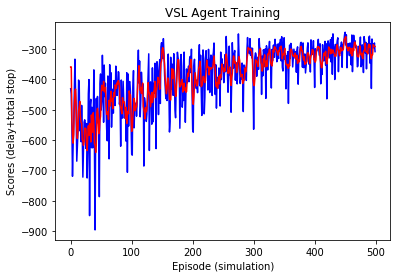

In [331]:
fig = plt.figure()#figsize=(10, 6))
plt.plot(np.arange(len(track_scores)), track_scores, color='b')
plt.plot(np.arange(len(track_scores)), window_avg(track_scores.squeeze(),4), color='r')
plt.ylabel('Scores (delay+total stop)')
plt.xlabel('Episode (simulation)')
plt.ylim()
plt.title('VSL Agent Training')
plt.show()
#fig.savefig('result/train_plot.png', bbox_inches = 'tight')

In [332]:
# save the result
track_score = pd.DataFrame(track_scores)
track_score.to_csv('data/track_score_final2.csv', index=None, header=None)
# save the result
track_actions = pd.DataFrame(track_action)
track_actions.to_csv('data/track_action_final2.csv', index=None, header=None)

In [379]:
# previous model

In [380]:
track_score = pd.read_csv('data/track_score.csv',sep=',',header=None)
track_actions = pd.read_csv('data/track_action.csv',sep=',',header=None)

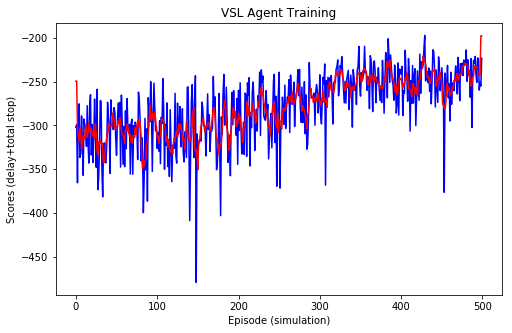

In [663]:
fig = plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(track_score)), track_score, color='b')
plt.plot(np.arange(len(track_score)), window_avg(track_score.squeeze(),5), color='r')
plt.ylabel('Scores (delay+total stop)')
plt.xlabel('Episode (simulation)')
plt.ylim()
plt.title('VSL Agent Training')
plt.show()
fig.savefig('result/train_plot.png', bbox_inches = 'tight')

### Model Evaluation

In [434]:
# Model Evaluation
fix_vissim_seed = np.random.randint(1, 10**3, 10)
def model_test(test_type, test_sim=2, max_ts=1500, preset_vissim_seed=fix_vissim_seed):
    # initialize the enviroinment
    env = vissim_environment()
    env.stop()
    
    # load the trained agent
    agent = VSL_Agent(state_space=8, action_space=8, seed=20)
    agent.Qnet_eval.load_state_dict(torch.load('trained_model/model_vsl.pth'))
    
    test_evaluate = [] # evaluation act_vehicle, exit_vehicle, delay, stop, tt
    test_scores = [] # store the test score
    test_vsl = []  # track the changes for vsl
    collect_info = [] # store the data colection info for each simulation

    for i_test in range(1, test_sim+1):
        start = time.time()
        
        state, _, evaluate_df = env.reset(initial_speed=65, vissim_seed=int(preset_vissim_seed[i_test-1]))
        
        score = 0.0
        action_sim = []
        evaluate_sim = []

        # total length is 12600 seconds for 1 simulation, break at each 5-mins
        for time_step in range(1200, max_ts, 300):
            if test_type == 'fixed':
                action = 3
            else:
                action = agent.act(state, eps=0.)
            
            state, reward, done, evaluate_df = env.step(action, time_step)
            score += reward
            # track vsl changes
            action_sim.append(action)
            # track link network performance
            evaluate_sim.append(evaluate_df)

            if done:
                break

        test_scores.append(score)
        test_vsl.append(action_sim)
        test_evaluate.append(evaluate_sim)
        # data collection info for entire simulation
        collect_info.append(speed_dist())

        end = time.time()

        print('simulation {}'.format(i_test))
        print('Time used: {}s'.format(round(end-start, 1)))
        print('scores {}'.format(score))
    return test_scores, test_vsl, test_evaluate, collect_info

In [435]:
fix_vissim_seed

array([ 65,  80, 885, 901, 509, 790, 984, 869, 173, 173])

In [436]:
d_scores, d_vsl, d_evaluate, d_info = model_test(test_type='dynamic', test_sim=5, max_ts=12900)
f_scores, f_vsl, f_evaluate, f_info = model_test(test_type='fixed', test_sim=5, max_ts=12900)

simulation 1
Time used: 130.7s
scores [-270.32126306]
simulation 2
Time used: 109.2s
scores [-253.66840385]
simulation 3
Time used: 113.0s
scores [-255.04569338]
simulation 4
Time used: 117.1s
scores [-266.27204479]
simulation 5
Time used: 108.0s
scores [-312.26282347]
simulation 1
Time used: 105.5s
scores [-262.88821773]
simulation 2
Time used: 103.2s
scores [-255.01589856]
simulation 3
Time used: 117.4s
scores [-244.83950546]
simulation 4
Time used: 104.5s
scores [-285.64009353]
simulation 5
Time used: 100.9s
scores [-323.54177876]


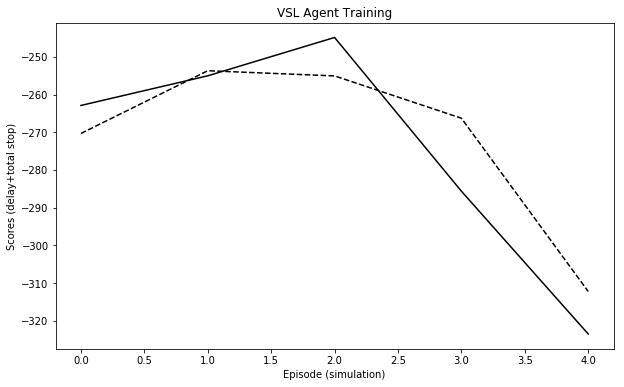

In [437]:
d_scores = np.array(d_scores)
f_scores = np.array(f_scores)
fig = plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(d_scores)), d_scores, linestyle='--', color = 'black', label='Dynamic SL')
plt.plot(np.arange(len(f_scores)), f_scores, linestyle='-', color = 'black', label='fixed SL')
plt.ylabel('Scores (delay+total stop)')
plt.xlabel('Episode (simulation)')
plt.ylim()
plt.title('VSL Agent Training')
plt.show()

In [438]:
import pickle

In [439]:
d_dict = {'d_scores':d_scores, 'd_vsl':d_vsl, 'd_evaluate':d_evaluate, 'd_info':d_info}
d_outfile = open('data/d_res_500','wb')
pickle.dump(d_dict,d_outfile)

In [440]:
f_dict = {'f_scores':f_scores, 'f_vsl':f_vsl, 'f_evaluate':f_evaluate, 'f_info':f_info}
f_outfile = open('data/f_res_500','wb')
pickle.dump(f_dict,f_outfile)

In [455]:
ff_evaluate

[[array([3.02000000e+02, 3.62000000e+02, 5.92657378e+00, 3.01204819e-03,
         2.40724864e+02]),
  array([2.34000000e+02, 4.10000000e+02, 7.49236110e+00, 1.39751553e-02,
         2.40875095e+02]),
  array([292.        , 342.        ,   4.41790541,   0.        ,
         239.10868021]),
  array([304.        , 404.        ,   6.08987184,   0.        ,
         240.08217947]),
  array([2.99000000e+02, 4.29000000e+02, 6.26190413e+00, 4.12087912e-03,
         2.40272010e+02]),
  array([2.53000000e+02, 4.16000000e+02, 5.66571894e+00, 1.49476831e-03,
         2.38611903e+02]),
  array([3.33000000e+02, 3.87000000e+02, 8.68244683e+00, 3.05555556e-02,
         2.45005178e+02]),
  array([3.20000000e+02, 4.57000000e+02, 1.61442670e+01, 1.91763192e-01,
         2.59429077e+02]),
  array([2.76000000e+02, 4.48000000e+02, 6.60221903e+00, 8.28729282e-03,
         2.40258219e+02]),
  array([3.28000000e+02, 4.01000000e+02, 8.09545444e+00, 1.09739369e-02,
         2.42763356e+02]),
  array([2.87000000e

In [459]:
fix_vissim_seed

array([ 65,  80, 885, 901, 509, 790, 984, 869, 173, 173])

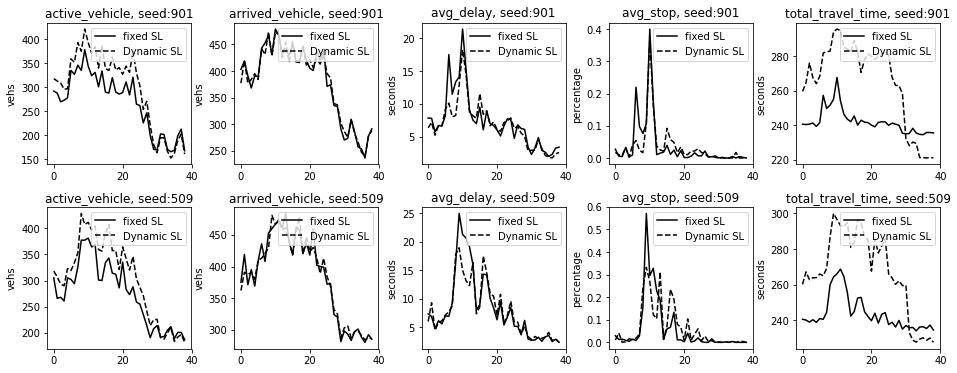

In [466]:
eval_start = 3
eval_end = 5

vissim_seedd = fix_vissim_seed[eval_start:eval_end]
ff_evaluate = f_evaluate[eval_start:eval_end]
dd_evaluate = d_evaluate[eval_start:eval_end]

column_name = ['active_vehicle', 'arrived_vehicle', 'avg_delay','avg_stop', 'total_travel_time']
total_simlation = eval_end-eval_start

y_labels = ['vehs','vehs','seconds','percentage','seconds']

fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(total_simlation, len(column_name), wspace=0.3, hspace=0.3)

for id_sim in range(total_simlation):
    ff = pd.DataFrame(np.array(ff_evaluate[id_sim]),columns=column_name)
    dd = pd.DataFrame(np.array(dd_evaluate[id_sim]),columns=column_name)
    for i in range(len(ff.columns)):
        plt.subplot(gs[id_sim,i])
        plt.title('{}, seed:{}'.format(ff.columns[i], vissim_seedd[id_sim]))
        plt.plot(np.arange(len(ff)), ff[ff.columns[i]], linestyle='-', color = 'black', label='fixed SL')
        plt.plot(np.arange(len(dd)), dd[dd.columns[i]], linestyle='--', color = 'black', label='Dynamic SL')
        
        plt.ylabel('{}'.format(y_labels[i]))
        plt.legend(loc='upper right')

#plt.suptitle('Simulation {}'.format(id_sim))
plt.show()
fig.savefig('result/net_work_performance.png', bbox_inches = 'tight')

In [517]:
def povit_shape(res_):
    res = pd.pivot_table(res_, index=['Name'], columns=['time_interval'], values=['speed'])
    res.columns = [str(int(j)) for i,j in res.columns]
    #res = np.array(res.reset_index())
    return res

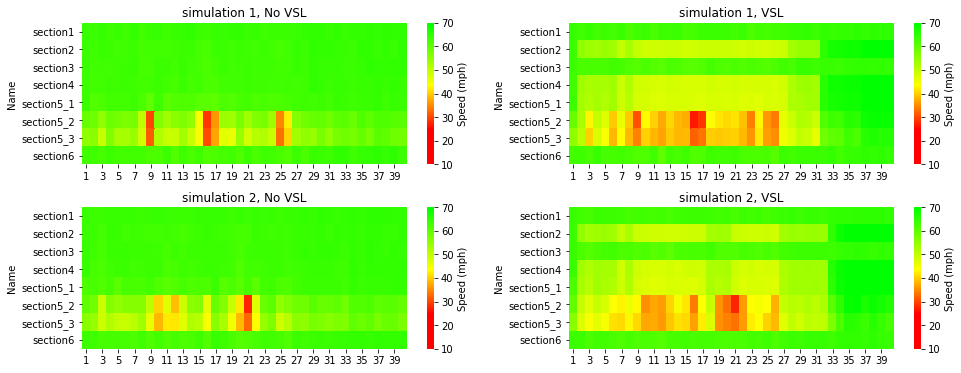

In [637]:
eval_start = 3
eval_end = 5

dd_info = d_info[eval_start:eval_end]
ff_info = d_info[eval_start:eval_end]

fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.3)

for i in range(len(dd_info)):
    speed_heat_d = povit_shape(d_info[i])
    speed_heat_f = povit_shape(f_info[i])
    plt.subplot(gs[i,0])
    sns.heatmap(speed_heat_f, cmap=my_cmap,cbar=True, vmin=10, vmax=70,cbar_kws={'label': 'Speed (mph)'})
    plt.title('simulation {}, No VSL'.format(i+1))
    plt.subplot(gs[i,1])
    sns.heatmap(speed_heat_d, cmap=my_cmap,cbar=True, vmin=10, vmax=70,cbar_kws={'label': 'Speed (mph)'})
    plt.title('simulation {}, VSL'.format(i+1))
plt.show()
fig.savefig('result/speed_smoothing.png', bbox_inches = 'tight')

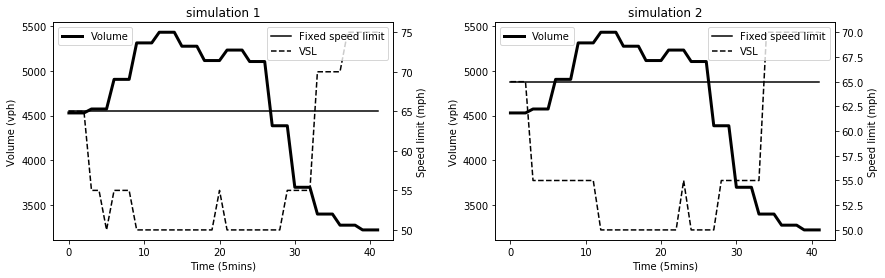

In [654]:
eval_start = 3
eval_end = 5

# plot volume
total_v = p1.hourly_v+R1+R2+R3
plot_v = np.repeat(np.array(total_v),3)

# plot speed limit
dd_vsl = d_vsl[eval_start:eval_end]
ff_vsl = f_vsl[eval_start:eval_end]

# warmup speed
warm_speed = np.array([65,65,65]).astype(np.int)

fig = plt.figure(figsize=(14,4))
gs = gridspec.GridSpec(1, 2, wspace=0.3, hspace=0.3)

for i in range(len(ff_vsl)):
    ddd_vsl = np.array([s*5+50 for s in dd_vsl[i]])
    ddd_vsl = np.concatenate((warm_speed,ddd_vsl))
    fff_vsl = np.array([s*5+50 for s in ff_vsl[i]])
    fff_vsl = np.concatenate((warm_speed,fff_vsl))
    ax1 = plt.subplot(gs[i])
    ax1.set_xlabel('Time (5mins)')
    ax1.set_ylabel('Volume (vph)')
    ax1.plot(plot_v, 'k-',lw=3, label='Volume')
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    ax2.plot(fff_vsl, 'k-',label='Fixed speed limit')
    ax2.plot(ddd_vsl, 'k--',label='VSL')
    ax2.set_ylabel('Speed limit (mph)')
    ax2.legend(loc='upper right')
    plt.title('simulation {}'.format(i+1))

plt.show()
fig.savefig('result/speed_limit_vs_volume.png', bbox_inches = 'tight')